In [84]:
# modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import chardet
import csv
import os
import matplotlib.dates as mdates
from IPython.display import Image
from scipy import stats

## Inserez les chemins vers le fichiers CSV:

In [85]:
# on récupère les informations du dossier
dossier = './raw_data'
contenuDossier = os.listdir(dossier)
print(contenuDossier)
nombrePoints = 0
nomPoints = []
numeroPoints = []
# on parcours le dossier en recherchant les fichiers des points
for x in contenuDossier:
    if x.startswith('point') :
        nombrePoints += 1
        nomPoints.append(x)
        numeroPoints.append(x[5:7])
print(nomPoints)
# nomPoints.remove('point51_131023')
# nomPoints.remove('point50_131023')
numeroPoints.remove('15')
# numeroPoints.remove('50')
# numeroPoints.remove('51')
print(numeroPoints)

['point35', 'point14_29_07_15', 'point15_29_07_15', 'point50_131023', 'schema_dispositif_AvAv_23_07_15.png', 'point47_27_08_19', 'point13_29_07_15', 'point36_12_07_16', 'point51_131023', 'point46_17_06_19', 'point34_27_06_16', 'point48_14_04_18']
['point35', 'point14_29_07_15', 'point15_29_07_15', 'point50_131023', 'point47_27_08_19', 'point13_29_07_15', 'point36_12_07_16', 'point51_131023', 'point46_17_06_19', 'point34_27_06_16', 'point48_14_04_18']
['35', '14', '50', '47', '13', '36', '51', '46', '34', '48']


In [86]:
def read_csv (chemin_fichier):
    #Detecter separateur
    with open(chemin_fichier, 'r') as file:
        sniffer = csv.Sniffer()
        sample_data = file.read(1024)
        detecter_separateur = (sniffer.sniff(sample_data).delimiter)

    if "Titre" in open(chemin_fichier).readline():
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur, skiprows=1)
    else:
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur)

    return data_frame 

In [87]:
# on crée un dictionnaire avec toutes les informations pour chaque point et on met les dictionnaires dans une liste
data = []
for x in nomPoints :
    dico = {}
    # le numéro
    dico['numero'] = x[5:7]
    # le nom
    dico['nom'] = x
    # la date
    dico['date'] = x[8:18]
    # le chemin vers le dossier
    dico['chemin'] = dossier + '/' + x
    with open(dico['chemin'] + '/geometrie.txt', 'r') as fichier:
        lignes = fichier.readlines()
        # le nom du capteur
        dico['capteur'] = lignes[1][:-1]
        # la profondeur du capteur
        if lignes[3] == '\n' :
            dico['profondeur'] = 0
        else : 
            dico['profondeur'] = lignes[3]
        # les profondeurs auquelles on fait les mesures
        dico['profondeurMesures'] = []
        profMes = lignes[5].split(';')
        for num in profMes :
            dico['profondeurMesures'].append(int(num))
    # on va ensuite mettre les dataframes dans le dictionnaire
    contenuDossierPoint = os.listdir(dico['chemin'])
    for x in contenuDossierPoint:
        # la pression
        if (x.startswith('p') and x.endswith('.csv')) and not x.endswith('cleaned.csv') :
            dico['pression'] = read_csv(dico['chemin'] + '/' + x)
        # la température
        if x.startswith('t') and x.endswith('.csv'):
            dico['temperature'] = read_csv(dico['chemin'] + '/' + x)
    # dans les configurations du capteur on va chercher les données
    chemin_etalonnage = 'configuration/pressure_sensors/P' + dico['capteur'][1:] +'.csv'
    if os.path.exists(chemin_etalonnage):
        with open(chemin_etalonnage) as fichier :
            lignes = fichier.readlines()
            for l in lignes :
                if l.startswith('Intercept') :
                    dico['intercept'] = float(l[10:-2])
                if l.startswith('dU/dH') :
                    dico['dU/dH'] = float(l[6:-2])
                if l.startswith('dU/dT') :
                    dico['dU/dT'] = float(l[6:-2])
    data.append(dico)


In [88]:


data[6]['pression']['Date Heure, GMT+01:00'].is_monotonic_increasing
#data[5]['numero']

False

In [89]:
# en faisant data[0] on a accès à toutes les informations du point 1
data[2]

{'numero': '15',
 'nom': 'point15_29_07_15',
 'date': '29_07_15',
 'chemin': './raw_data/point15_29_07_15',
 'capteur': 'p506',
 'profondeur': 0,
 'profondeurMesures': [7, 22, 37, 52],
 'temperature':        # Date Heure, GMT+02:00  \
 0      1  07/23/15 02:00:00 PM   
 1      2  07/23/15 02:15:00 PM   
 2      3  07/23/15 02:30:00 PM   
 3      4  07/23/15 02:45:00 PM   
 4      5  07/23/15 03:00:00 PM   
 ..   ...                   ...   
 559  560  07/29/15 09:45:00 AM   
 560  561  07/29/15 10:00:00 AM   
 561  562  07/29/15 10:15:00 AM   
 562  563  07/29/15 10:30:00 AM   
 563  564  07/29/15 10:45:00 AM   
 
      Temp. °C (LGR S/N: 10445474, SEN S/N: 10445474)  \
 0                                             28.320   
 1                                             27.333   
 2                                             27.505   
 3                                             27.949   
 4                                             26.671   
 ..                                 

# Est ce que les fichiers peuvent être utilisés ?

**Dans notre cas, nous prendrons ces solutions**

* S'il manque toutes les données du capteurs de pression ou l'étalonnage, nous déciderons que ce point est invalide.
* S'il manque une partie des données nous vérifierons que nous avons au mimimun 7 jours de données
* S'il manque plus de 2 capteurs de température, nous déciderons que ce point est invalide.

### Est ce que nous avons les données de l'étalonnage du capteur ?

In [90]:
for x in data :
    if not 'intercept' in x.keys() :
        print('le point '+ x['numero'] + ' n\'a pas d\'étalonnage, il n\'est pas valide')
        data.remove(x)

### Est ce que nous avons des données pour le capteur de pression ?

In [91]:
for x in data :
    if x['pression'].empty :
        print('le point '+ x['numero'] + ' n\'a pas de données de pression, il n\'est pas valide')
        data.remove(x)

In [92]:
data[5]

{'numero': '13',
 'nom': 'point13_29_07_15',
 'date': '29_07_15',
 'chemin': './raw_data/point13_29_07_15',
 'capteur': 'p505',
 'profondeur': 0,
 'profondeurMesures': [10, 20, 30, 40],
 'pression':        # Date Heure, GMT+02:00  \
 0      1  07/23/15 02:00:00 PM   
 1      2  07/23/15 02:15:00 PM   
 2      3  07/23/15 02:30:00 PM   
 3      4  07/23/15 02:45:00 PM   
 4      5  07/23/15 03:00:00 PM   
 ..   ...                   ...   
 558  559  07/29/15 09:30:00 AM   
 559  560  07/29/15 09:45:00 AM   
 560  561  07/29/15 10:00:00 AM   
 561  562  07/29/15 10:15:00 AM   
 562  563  07/29/15 10:30:00 AM   
 
      Tension, V (LGR S/N: 10117169, SEN S/N: 10117169)  \
 0                                              0.58181   
 1                                              0.58059   
 2                                              0.57937   
 3                                              0.57937   
 4                                              0.57937   
 ..                       

### On modifie les nom des colonnes du dataframe

In [93]:
# pour les températures
l=0
for x in data :
    # on supprime les colonnes qui ne servent à rien
    for i in x['temperature'].columns :
        if not( i.startswith(('Date', 'dates', 'temp','Temp'))) :
            del x['temperature'][i]
    for i in x['pression'].columns :
        if not( i.startswith(('Date', 'dates', 'Tension', 'tension', 'pressure', 'temp', 'Temp'))) :
            del x['pression'][i]
    # on renomme les colonnes
    profondeur = x['profondeurMesures']
    #print(x['profondeurMesures'])
    colonnesT = ['dates']
    for num in profondeur :
        colonnesT.append('Temp_profondeur_'+ str(num))
    #print(colonnesT)
    # print(x['temperature'].columns)
    x['temperature'].columns = colonnesT
    colonnesP = ['dates', 'tension', 'temperature_stream']
    x['pression'].columns = colonnesP
    l+=1
    

In [94]:
# notamment la température et la pression
data[6]['temperature'].head(5)

,dates,Temp_profondeur_10,Temp_profondeur_20,Temp_profondeur_30,Temp_profondeur_40
0,07/12/16 02:00:00 PM,23.785,25.234,24.460,24.412
1,07/12/16 02:15:00 PM,17.463,16.892,16.677,537.327
2,07/12/16 02:30:00 PM,16.749,16.320,16.129,537.327
3,07/12/16 02:45:00 PM,16.725,16.272,16.082,537.327
4,07/12/16 03:00:00 PM,16.749,16.272,16.058,537.327


## Conversion de valeurs de tension a differance de charge

In [95]:
for point in data:
    k0 = float(point['intercept'])
    k1 = float(point['dU/dH'])
    k2 = float(point['dU/dT'])
    
    # Calcul de la colonne 'dH' en utilisant la formule H = 1/k1 * (U - k0 - k2 * T)
    U = point['pression']['tension'].astype(float)
    T = point['pression']['temperature_stream'].astype(float)
    point['pression']['dH'] = (1 / k1) * (U - k0 - k2 * T)

data[0]['pression']

,dates,tension,temperature_stream,dH
0,07/12/16 12:00:00 PM,1.56471,20.007,-0.222196
1,07/12/16 12:15:00 PM,0.62210,14.361,0.416653
2,07/12/16 12:30:00 PM,0.63614,14.314,0.407006
3,07/12/16 12:45:00 PM,0.69780,14.218,0.364748
4,07/12/16 01:00:00 PM,0.66911,14.098,0.384245
...,...,...,...,...
2106,08/03/16 10:30:00 AM,2.49939,14.314,-0.867020
2107,08/03/16 10:45:00 AM,2.49939,17.558,-0.863760
2108,08/03/16 11:00:00 AM,2.49939,18.129,-0.863186
2109,08/03/16 11:06:59 AM,NaN,NaN,NaN


### On enlève les valeurs Nan

In [96]:
for x in data :
    x['temperature'] = x['temperature'].dropna(axis = 0, how = 'any')
    x['pression'] = x['pression'].dropna(axis = 0, how='any')

In [97]:
from dateutil import parser

# Conversion dans le bon format date
for x in data:
    x['pression']['dates'] = x['pression']['dates'].apply(lambda x: parser.parse(x).strftime('%d-%m-%Y %H:%M'))
    x['temperature']['dates'] = x['temperature']['dates'].apply(lambda x: parser.parse(x).strftime('%d-%m-%Y %H:%M'))
#    point['pression']['dates'] = pd.to_datetime(point['pression']['dates'], format='mixed')
#    point['temperature']['dates'] = pd.to_datetime(point['temperature']['dates'], format='mixed')

/var/folders/95/14nx391x279gt37l3hnx_p_80000gn/T/ipykernel_87913/1590845049.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['pression']['dates'] = x['pression']['dates'].apply(lambda x: parser.parse(x).strftime('%d-%m-%Y %H:%M'))


In [98]:
data[0]['pression'].head(5)

,dates,tension,temperature_stream,dH
0,12-07-2016 12:00,1.56471,20.007,-0.222196
1,12-07-2016 12:15,0.62210,14.361,0.416653
2,12-07-2016 12:30,0.63614,14.314,0.407006
3,12-07-2016 12:45,0.69780,14.218,0.364748
4,12-07-2016 13:00,0.66911,14.098,0.384245


In [99]:
for x in data :
    # Traiter chaque colonne sauf la colonne des dates
    columns_to_processP = [col for col in x['pression'].columns if col != 'dates']
    columns_to_processT = [col for col in x['temperature'].columns if col != 'dates']
    # Créer un DataFrame vide pour stocker les données traitées
    x['pression2'] = x['pression'][['dates']].copy()
    x['temperature2'] = x['temperature'][['dates']].copy()
    # Boucler à travers chaque colonne à traiter
    for column_name in columns_to_processP :
        # Calculer le Z-score pour la colonne
        z_scores = np.abs(stats.zscore(x['pression'][column_name]))
        # Définir un seuil pour le Z-score (par exemple, 3)
        threshold = 3
        # Sélectionner les lignes avec des Z-scores inférieurs au seuil
        df_cleaned = x['pression'][z_scores < threshold] 
        # Copier les données traitées dans df_processed
        x['pression2'][column_name] = df_cleaned[column_name]
    # pareil pour les températures
    for column_name in columns_to_processT :
        # Calculer le Z-score pour la colonne
        z_scores = np.abs(stats.zscore(x['temperature'][column_name]))
        # Définir un seuil pour le Z-score (par exemple, 3)
        threshold = 3
        # Sélectionner les lignes avec des Z-scores inférieurs au seuil
        df_cleaned = x['temperature'][z_scores < threshold] 
        # Copier les données traitées dans df_processed
        x['temperature2'][column_name] = df_cleaned[column_name]

In [100]:
def nb_val_abberantes(capteur_riviere, capteur_ZH):
    df = capteur_ZH.copy()
    df["temperature_stream"] = capteur_riviere[["temperature_stream"]]
    df["dH"] = capteur_riviere[["dH"]]
    for column in df.columns:
        if column != "dates":
            print(f"Analyse pour la colonne : {column}")
            #plot_data_with_and_without_outliers(df, column)
            #print(f"Nombre de valeurs aberrantes : {count_outliers(df, column)}\n")
            
    # Créer un DataFrame vide pour stocker les données traitées
    df_processed = df[["dates"]].copy()

    # Boucler à travers chaque colonne de df
    for column_name in df.columns:
        if column_name == "dates":
            continue  # Ignorer la colonne des dates
            
        # Traiter la colonne et stocker les données traitées dans df_processed
        median, q1, q3, iqr, minimum, maximum = calculate_quantiles_iqr(df, column_name)
        df_processed[f"{column_name}"] = remove_outliers(df, column_name)[column_name]
        
    # Afficher les statistiques des données traitées
    print(df_processed.describe())
    return df, df_processed

In [101]:
# Fonction pour calculer les statistiques et les valeurs IQR
def calculate_quantiles_iqr(df, column_name):
    median = df[column_name].median()
    # Calculer les quantiles Q1 et Q3 pour la colonne spécifiée
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    
    # Calculer l'IQR
    iqr = q3 - q1
    minimum = q1 - 1.5 * iqr  # Valeur minimale (|- dans la boîte à moustaches)
    maximum = q3 + 1.5 * iqr  # Valeur maximale (-| dans la boîte à moustaches)
    return median, q1, q3, iqr, minimum, maximum

# Fonction pour obtenir un texte décrivant les statistiques de base
def get_iqr_text(df, col_name):
    # Calcul des statistiques de base
    median, q1, q3, iqr, minimum, maximum = calculate_quantiles_iqr(df, col_name)
    
    # Création du texte
    text = f"médiane={median:.2f}, Q1={q1:.2f}, Q3={q3:.2f}, IQR={iqr:.2f}, minimum={minimum:.2f}, maximum={maximum:.2f}"
    return text

# Fonction pour supprimer les valeurs aberrantes
def remove_outliers(df, col_name):
    # Obtention des limites pour les valeurs non aberrantes
    _, _, _, _, minimum, maximum = calculate_quantiles_iqr(df, col_name)
    
    # Sélection des lignes avec des valeurs non aberrantes
    df_out = df.loc[(df[col_name] > minimum) & (df[col_name] < maximum)]
    return df_out

# Fonction pour compter les valeurs aberrantes
def count_outliers(df_in, col_name):
    # Obtention des limites pour les valeurs aberrantes
    _, _, _, _, minimum, maximum = calculate_quantiles_iqr(df_in, col_name)
    
    # Sélection des lignes avec des valeurs aberrantes
    df_outliers = df_in.loc[(df_in[col_name] <= minimum) | (df_in[col_name] >= maximum)]
    
    # Comptage des valeurs aberrantes
    num_outliers = df_outliers.shape[0]
    return num_outliers

# Fonction pour générer un graphique de boîte à moustaches
def box_and_whisker(df_in, col_name):
    # Obtention du texte décrivant les statistiques
    title = get_iqr_text(df_in, col_name)
    
    # Tracé du graphique de boîte à moustaches
    sns.boxplot(df_in[col_name])
    plt.title(title)
    plt.show()

# Fonction pour tracer les données avec et sans valeurs aberrantes
def plot_data_with_and_without_outliers(df, col_name):
    plt.figure(figsize=(12, 6))
    
    # Tracé des données brutes
    plt.subplot(1, 2, 1)
    plt.title("Données brutes")
    sns.boxplot(df[col_name])
    
    # Tracé des données sans valeurs aberrantes
    plt.subplot(1, 2, 2)
    plt.title("Données sans valeurs aberrantes")
    df_cleaned = remove_outliers(df, col_name)
    sns.boxplot(df_cleaned[col_name])
    
    plt.tight_layout()
    plt.show()


In [102]:
for x in data :
    df_processed  = nb_val_abberantes(x['pression'], x['temperature'])[1]
    df_processed = df_processed.dropna(axis = 0, how='any')
    x['pression2'] = df_processed[['dates', 'temperature_stream', 'dH']].copy()
    x['temperature2'] = df_processed.drop(columns = [ 'temperature_stream','dH']).copy()

Analyse pour la colonne : Temp_profondeur_10
Analyse pour la colonne : Temp_profondeur_20
Analyse pour la colonne : Temp_profondeur_30
Analyse pour la colonne : Temp_profondeur_40
Analyse pour la colonne : temperature_stream
Analyse pour la colonne : dH
       Temp_profondeur_10  Temp_profondeur_20  Temp_profondeur_30  \
count         2090.000000         2044.000000         2024.000000   
mean            14.910749           14.063272           13.789086   
std              0.679988            0.366243            0.254697   
min             13.401000           13.137000           13.161000   
25%             14.433000           13.858000           13.714000   
50%             14.888000           14.098000           13.858000   
75%             15.366000           14.337000           13.978000   
max             16.820000           14.888000           14.385000   

       Temp_profondeur_40  temperature_stream           dH  
count         2045.000000         2106.000000  1820.000000  
me

In [103]:
for x in data :
    x['temperature2'] = x['temperature2'].dropna(axis = 0, how = 'any')
    x['pression2'] = x['pression2'].dropna(axis = 0, how='any')

In [104]:
# on met à jour la date de début de la mesure, la date de fin et la période
from datetime import datetime

for x in data :
    x['dateDebut'] = datetime.strptime(x['pression2']['dates'].iloc[0], '%d-%m-%Y %H:%M')
    x['dateFin'] = datetime.strptime(x['pression2']['dates'].iloc[x['pression2']['dates'].shape[0]-1], '%d-%m-%Y %H:%M')
    x['periode'] = x['dateFin'] - x['dateDebut']

In [105]:
# for x in data :
#     x['pression2']['dates'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M'))
#     x['temperature2']['dates'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M'))
#     x['pression']['dates'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M'))
#     x['temperature']['dates'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M'))

### Est ce que nous avons au minimum 3 jours de données ?

In [106]:
for x in data :
    if x['periode'].days <= 3 :
        print('le point ' + x['numero'] + ' n\'est pas valide car sa période est de seulement ' + str(x['periode'])[0] +' jours')
        data.remove(x)

le point 15 n'est pas valide car sa période est de seulement 0 jours


### Création du fichier `info.txt`

In [107]:
# Ouvrez un fichier en mode écriture ('w')
for x in data :
    if os.path.exists(x['chemin'] + '/point' + x['numero'] + '_info.txt') :
        os.remove(x['chemin'] + '/point' + x['numero'] + '_info.txt')
    with open(x['chemin'] + '/point' + x['numero'] + '_info.txt', 'w') as fichier:
        # Parcourez le dictionnaire et écrivez les données dans le fichier
        fichier.write('Point_Name,Point' + x['numero'] + '\n')
        fichier.write('P_Sensor_Name,' + x['capteur'] + '\n')
        fichier.write('Implantation_Date,' + x['date'] + '\n')
        fichier.write('Meas_date,' + str(x['dateDebut']) + '\n')
        fichier.write('River_Deb,' '\n') 
        fichier.write('Delta_h,' + '\n')
        fichier.write('Periode,' + str(x['periode']) + '\n')

In [108]:
data[2]['temperature2']

,dates,Temp_profondeur_10,Temp_profondeur_20,Temp_profondeur_30,Temp_profondeur_40
198,15-10-2023 11:15,12.251,13.102,13.617,14.018
199,15-10-2023 11:30,12.251,13.094,13.601,14.005
200,15-10-2023 11:45,12.263,13.087,13.586,13.990
201,15-10-2023 12:00,12.252,13.079,13.571,13.976
202,15-10-2023 12:15,12.245,13.072,13.557,13.963
...,...,...,...,...,...
1713,31-10-2023 06:00,12.567,12.803,12.906,13.020
1714,31-10-2023 06:15,12.554,12.793,12.901,13.019
1715,31-10-2023 06:30,12.544,12.784,12.895,13.016
1716,31-10-2023 06:45,12.533,12.773,12.889,13.014


# Traitement des signaux de temperature et pression

### Evaluer la correlation entre les signaux pour chaque point

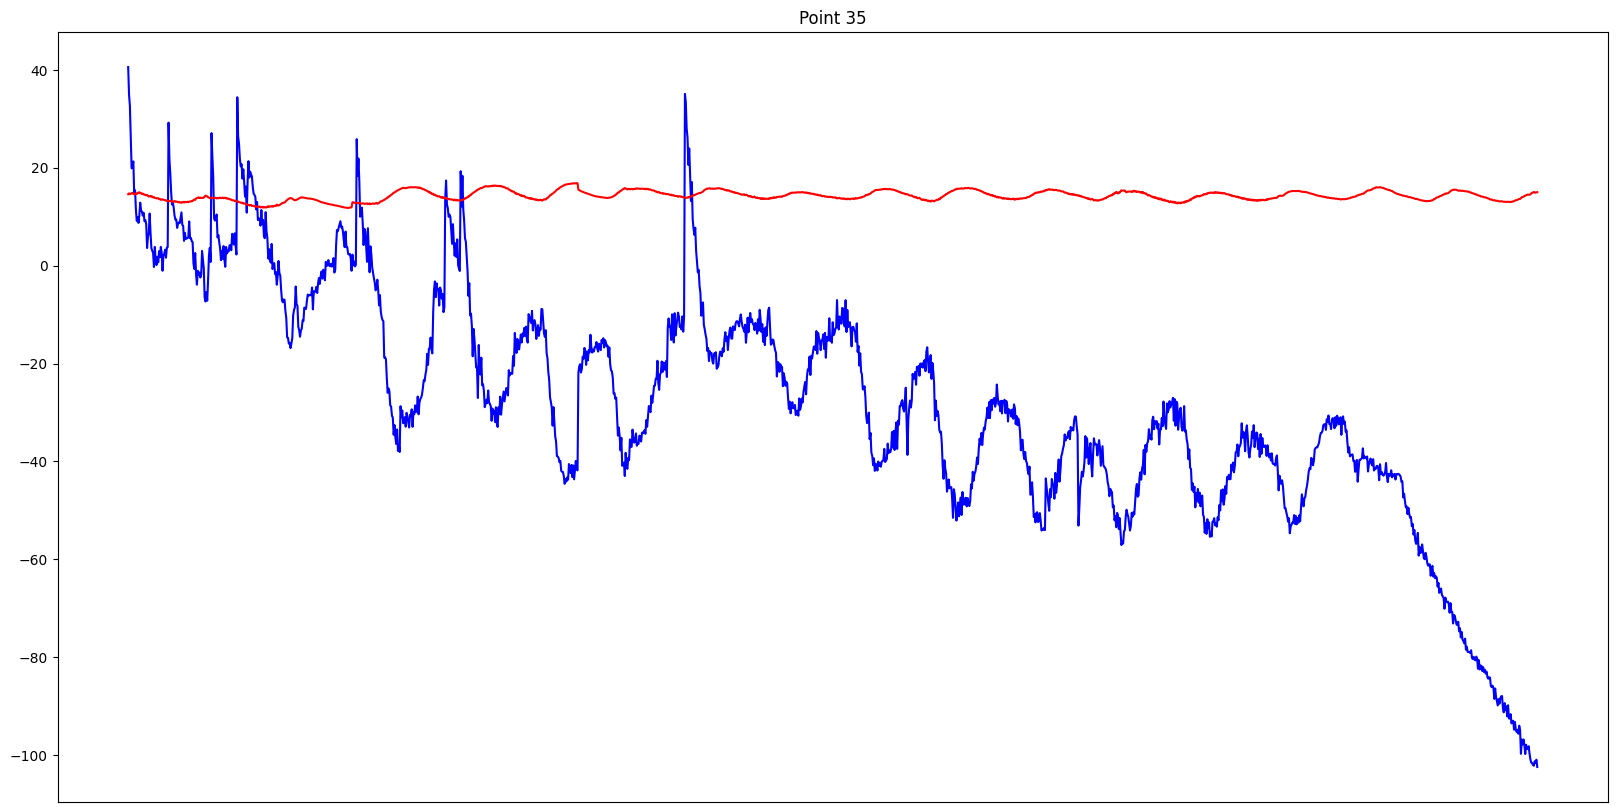

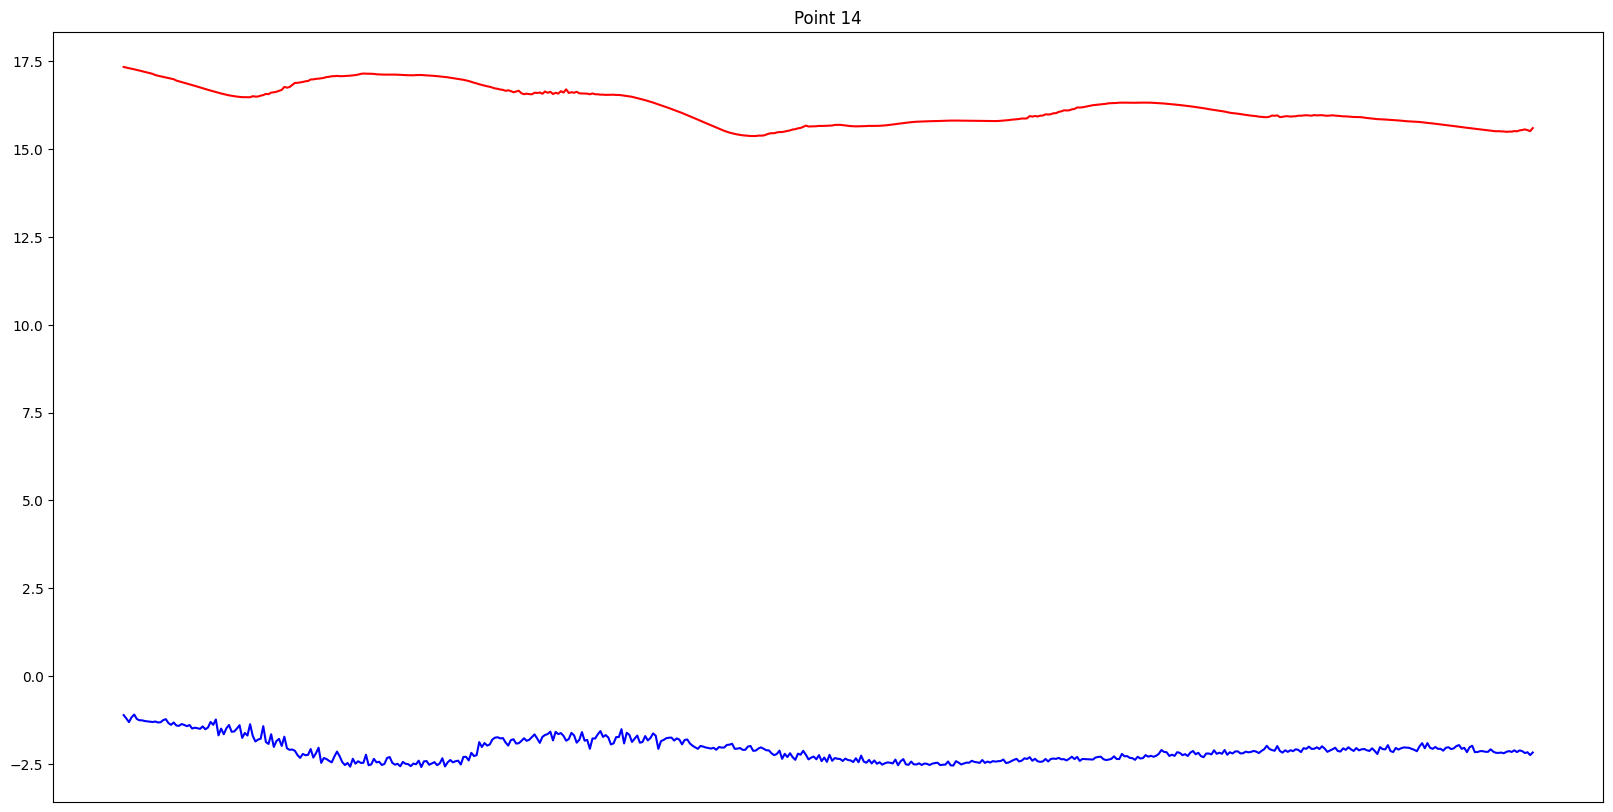

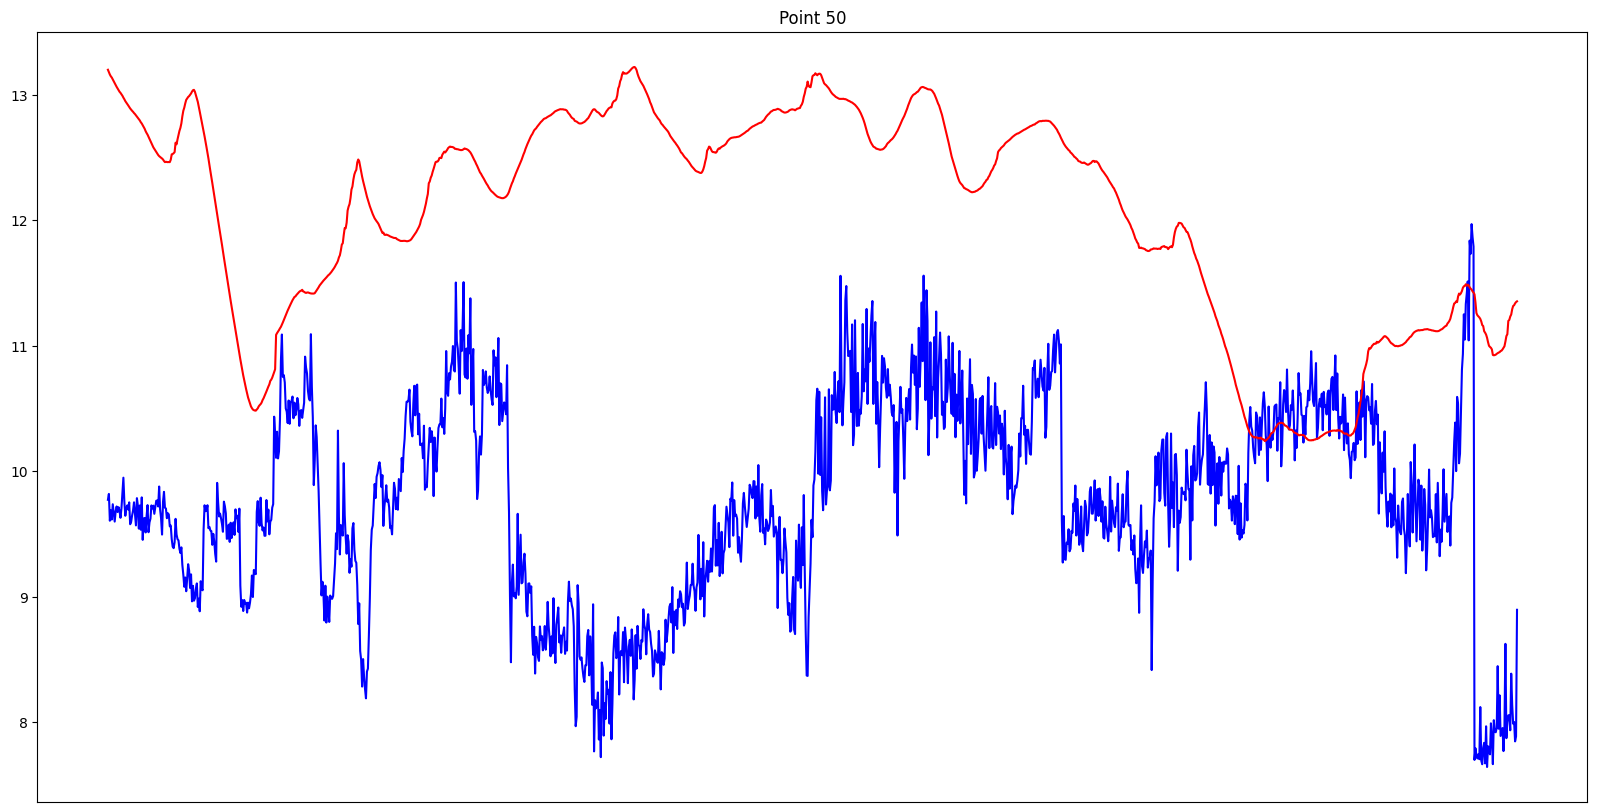

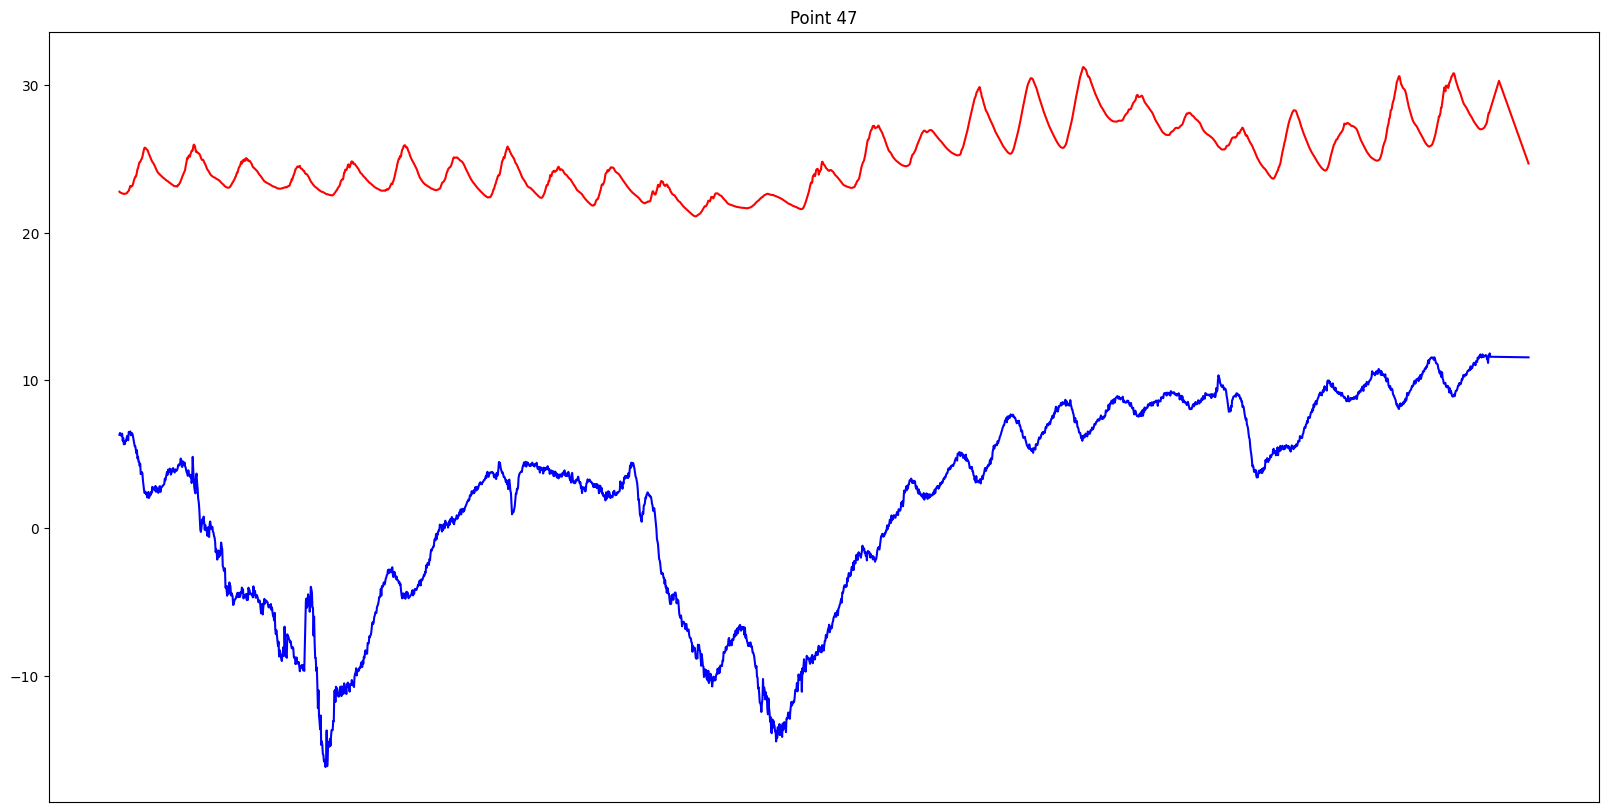

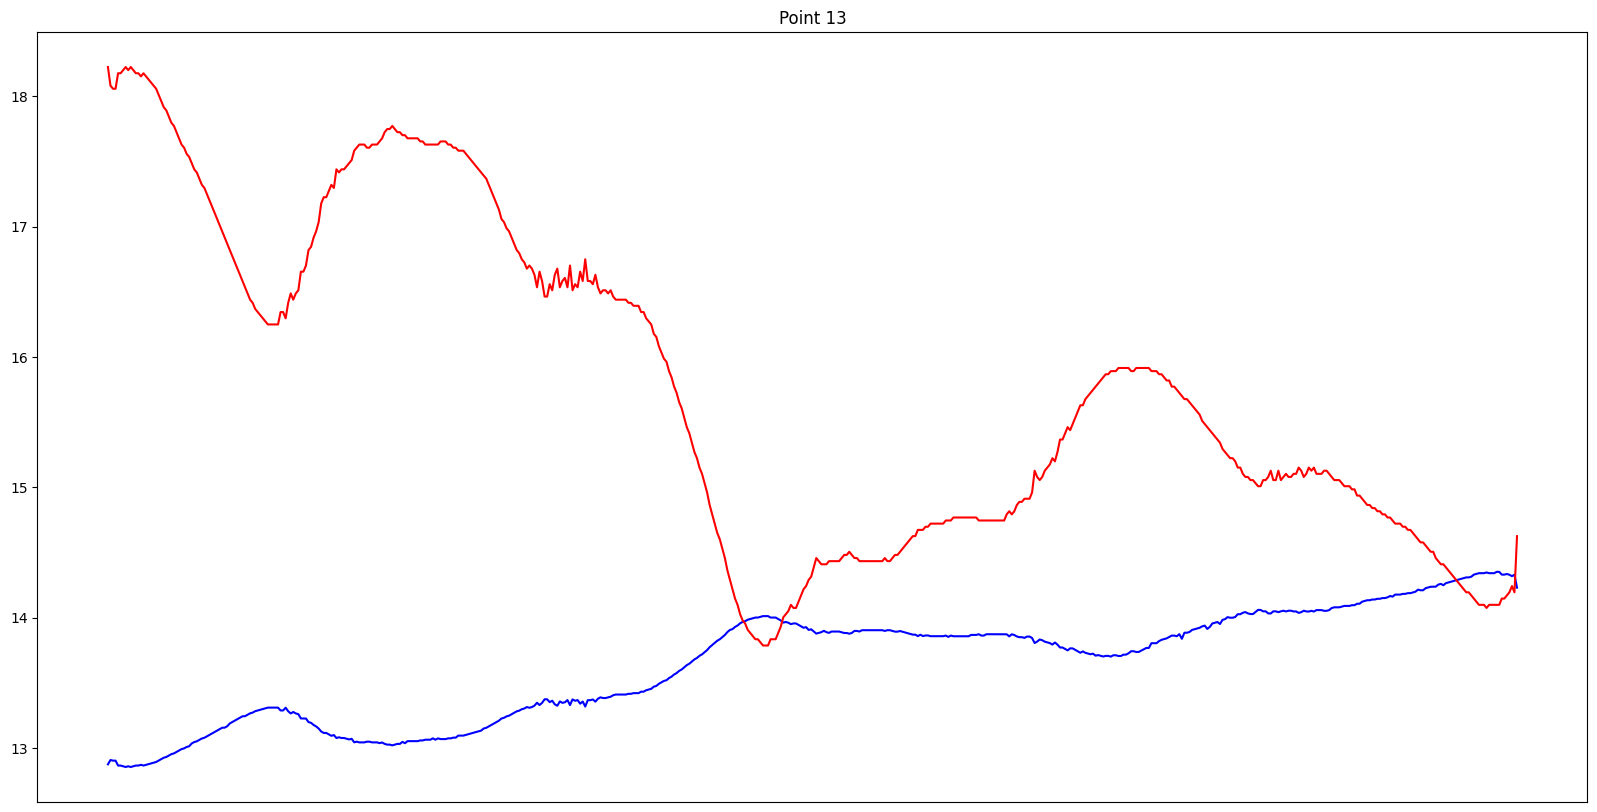

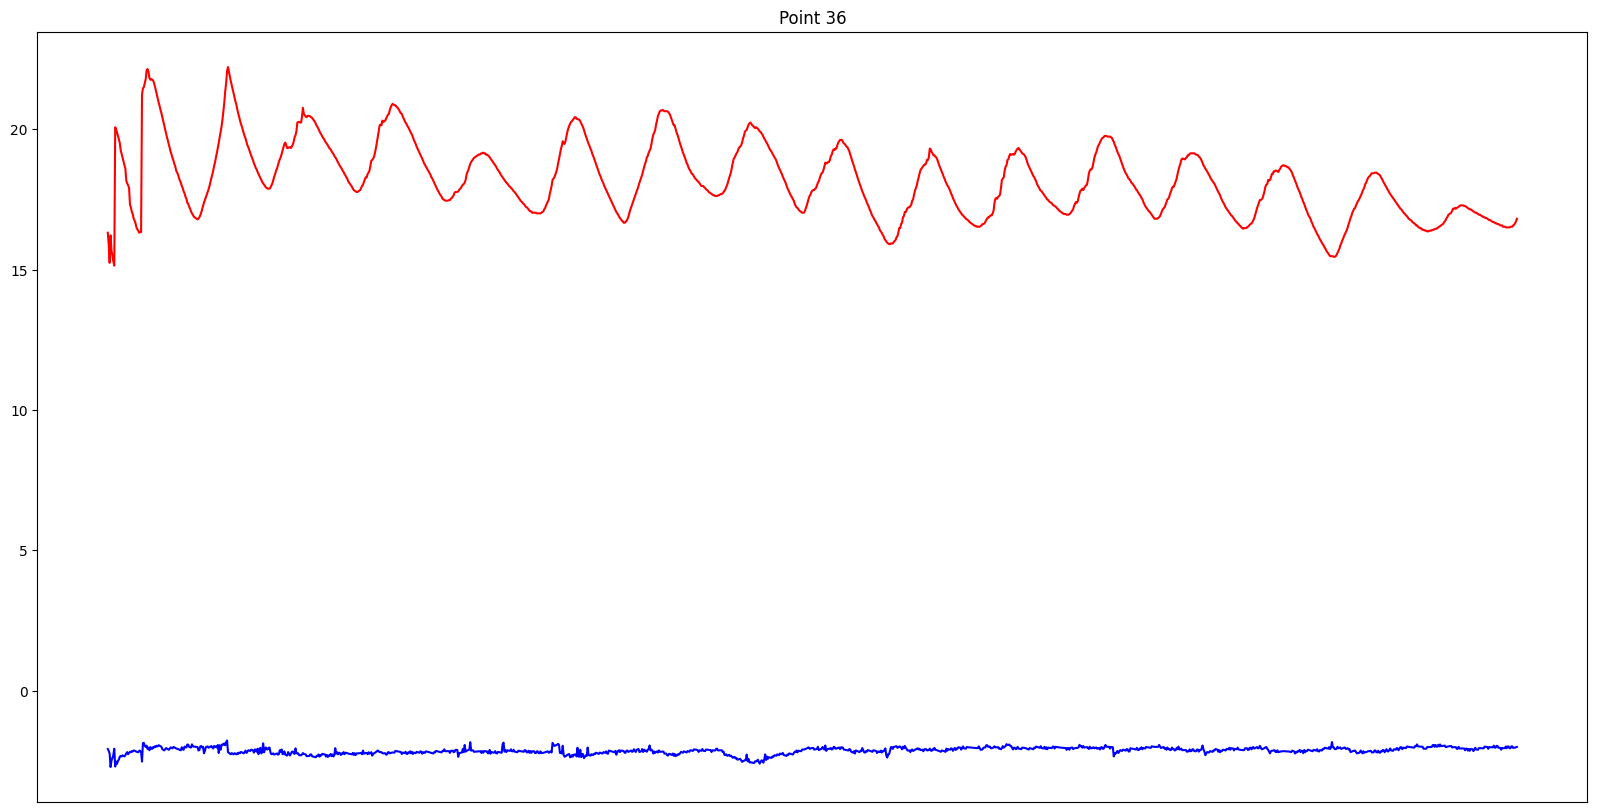

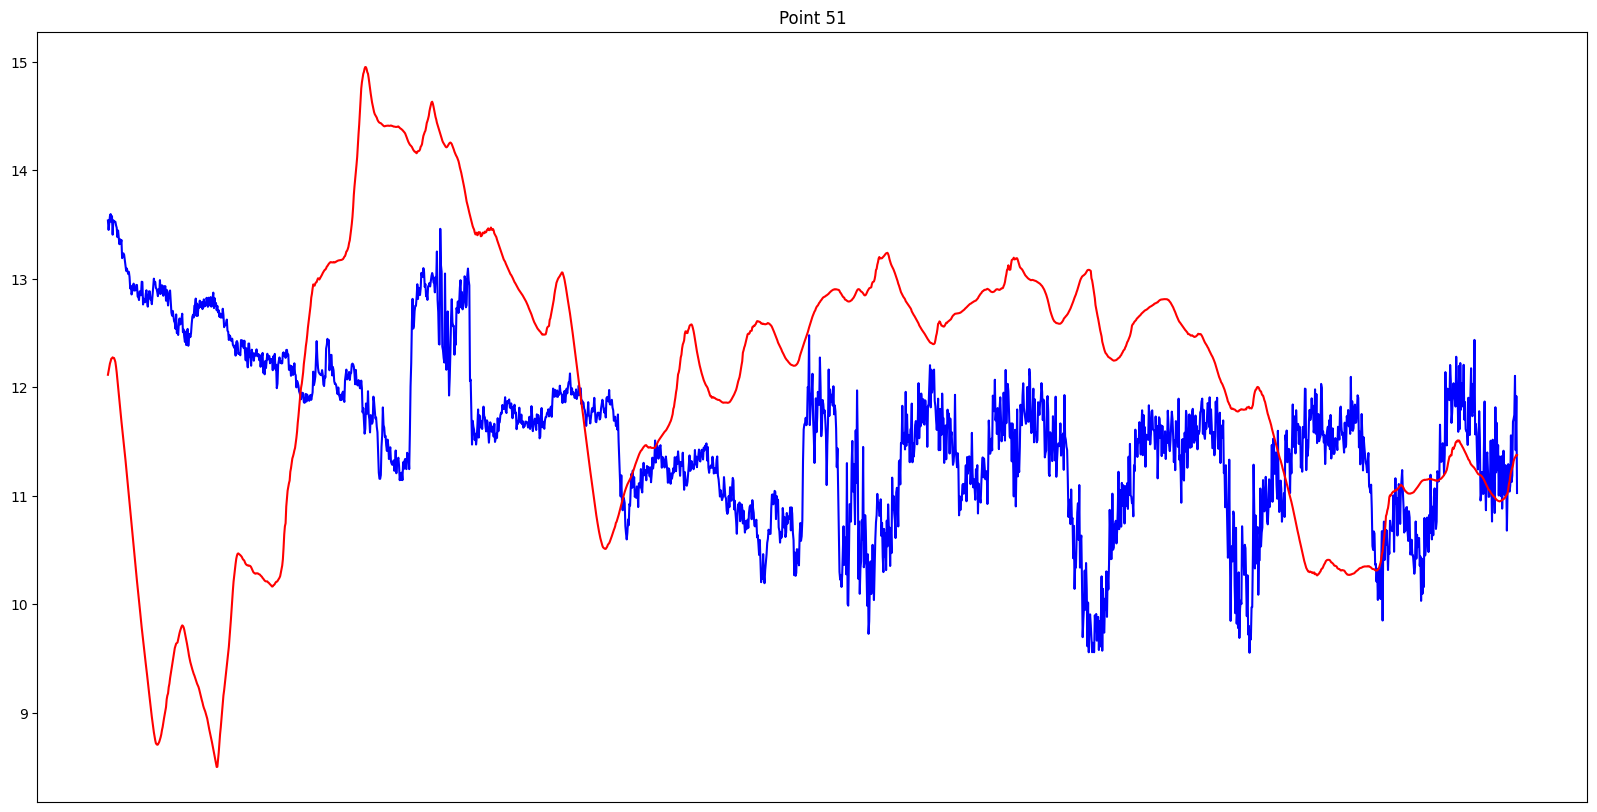

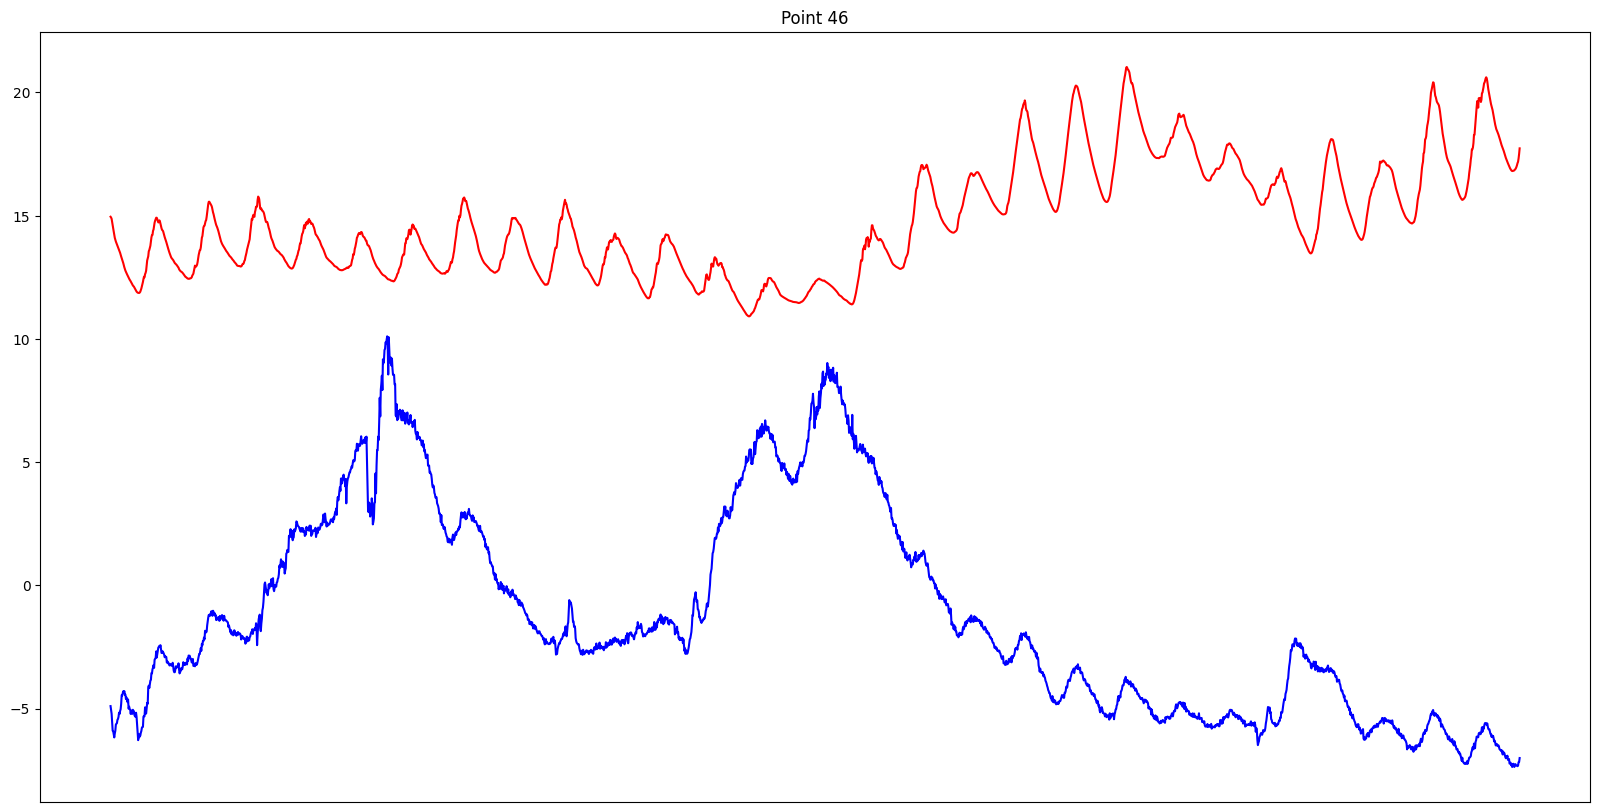

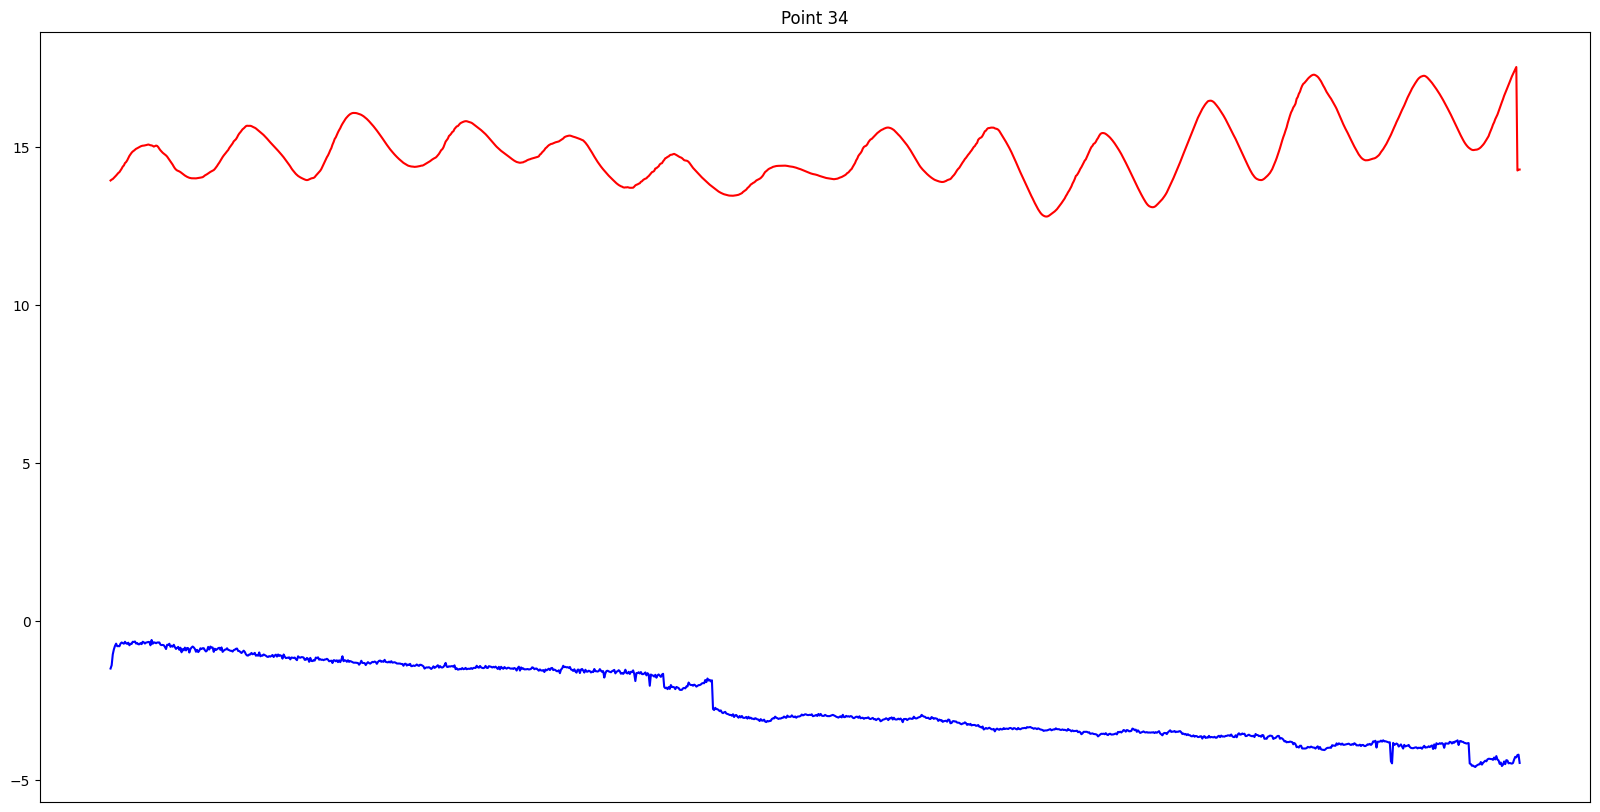

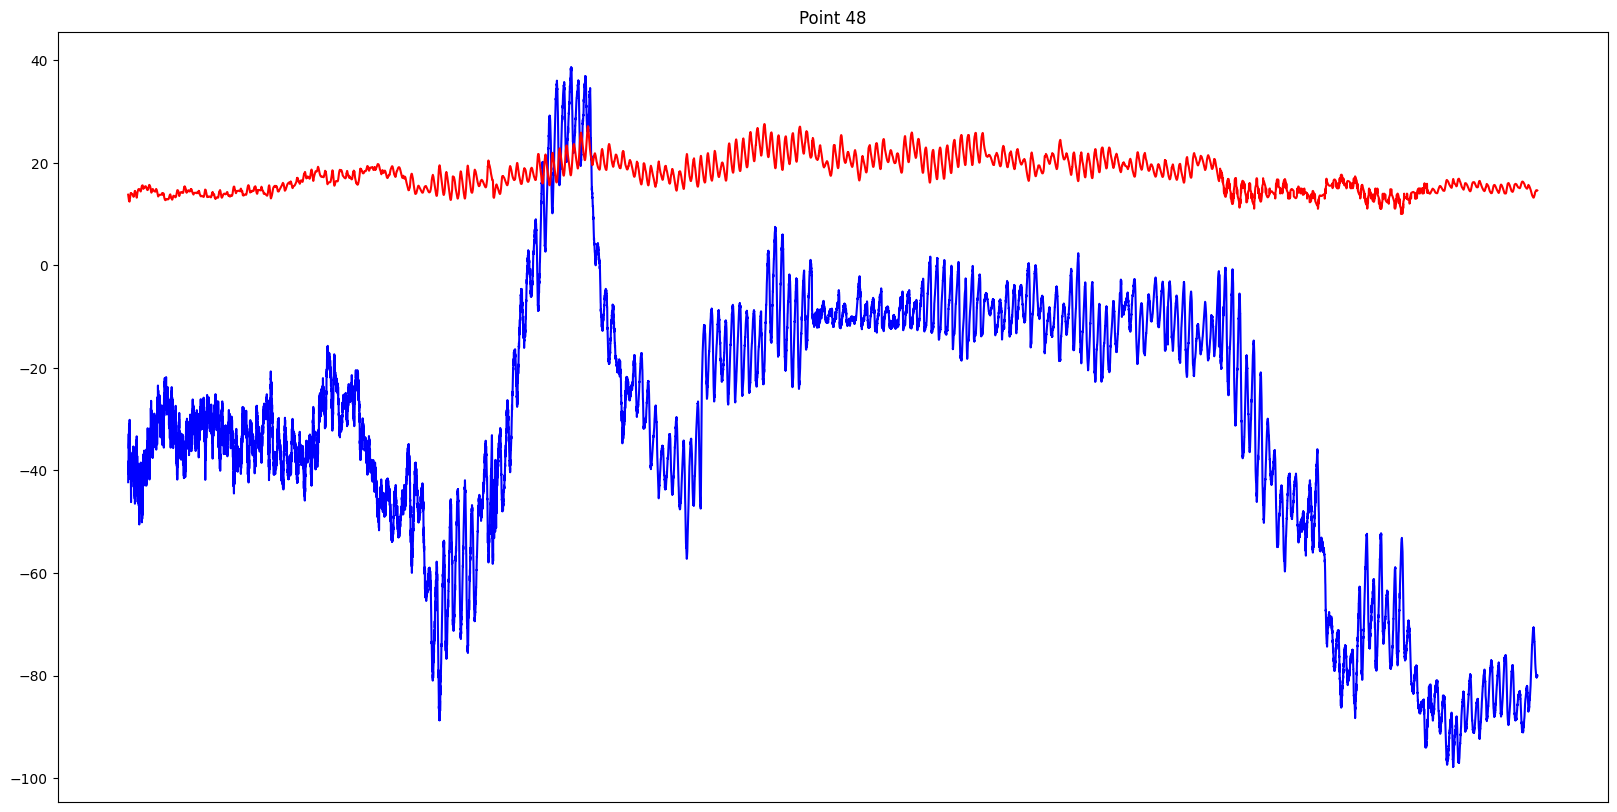

In [109]:
for i in range(len(numeroPoints)):
    plt.figure(figsize=(20,10))
    plt.xticks([])
    plt.plot(data[i]['pression2']['dates'], data[i]['pression2']['dH']*150, color = 'blue')
    plt.plot(data[i]['pression2']['dates'], data[i]['pression2']['temperature_stream'], color = 'red')
    plt.title('Point ' + numeroPoints[i])
    plt.show()

In [110]:
point_correler=['48','46','13','47','35']


### FFT


Point: 35
Point: 35
1641 1641


/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 2000x1000 with 0 Axes>

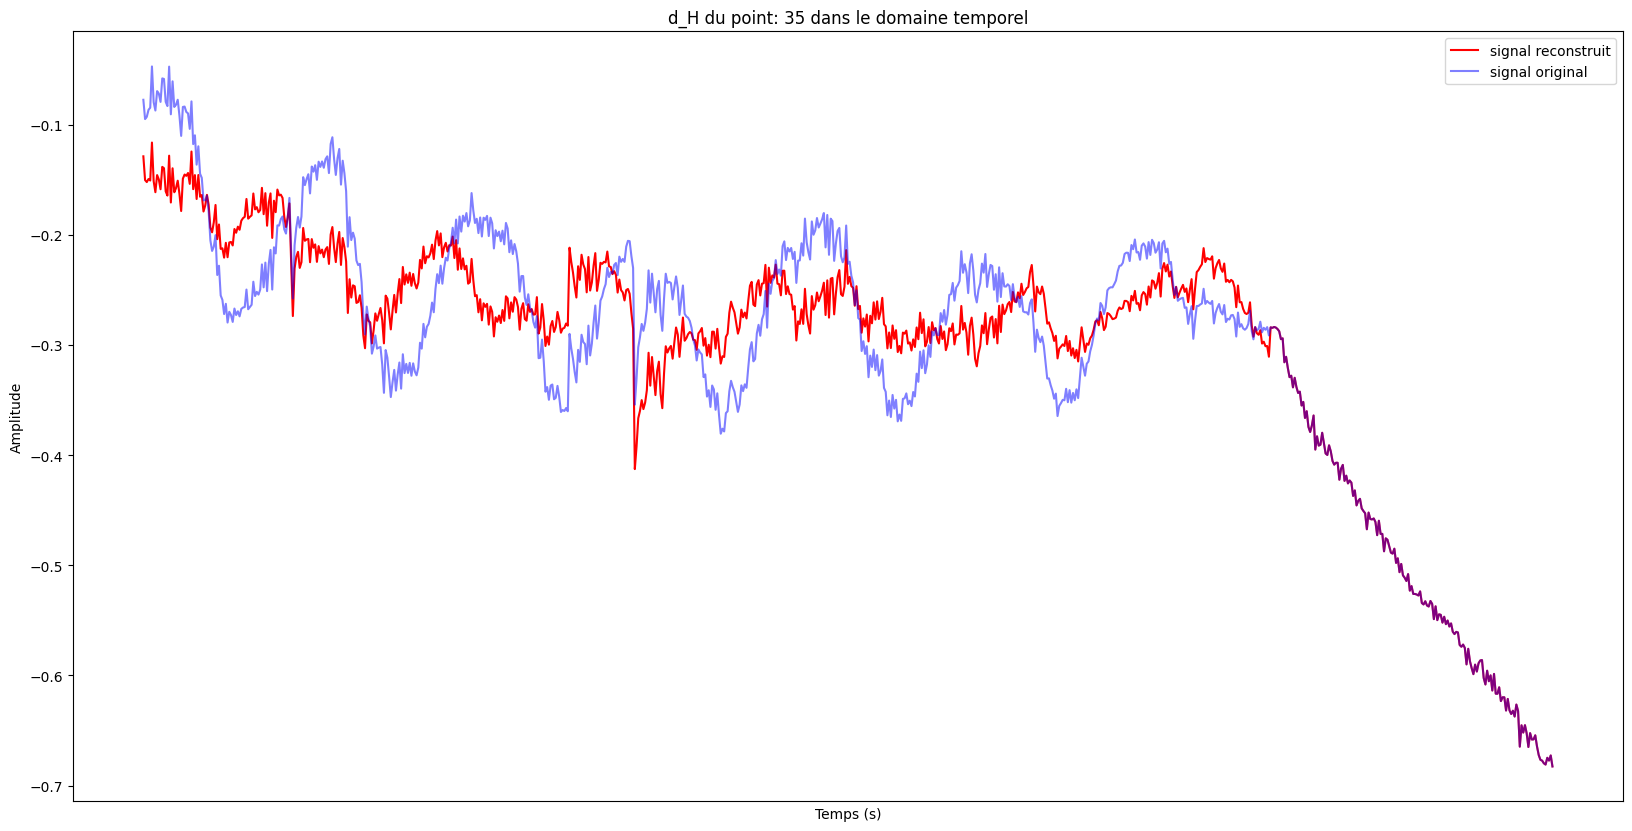

1641 1641
Point: 14
536 536
Point: 50
1459 1459
Point: 47
Point: 47


/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


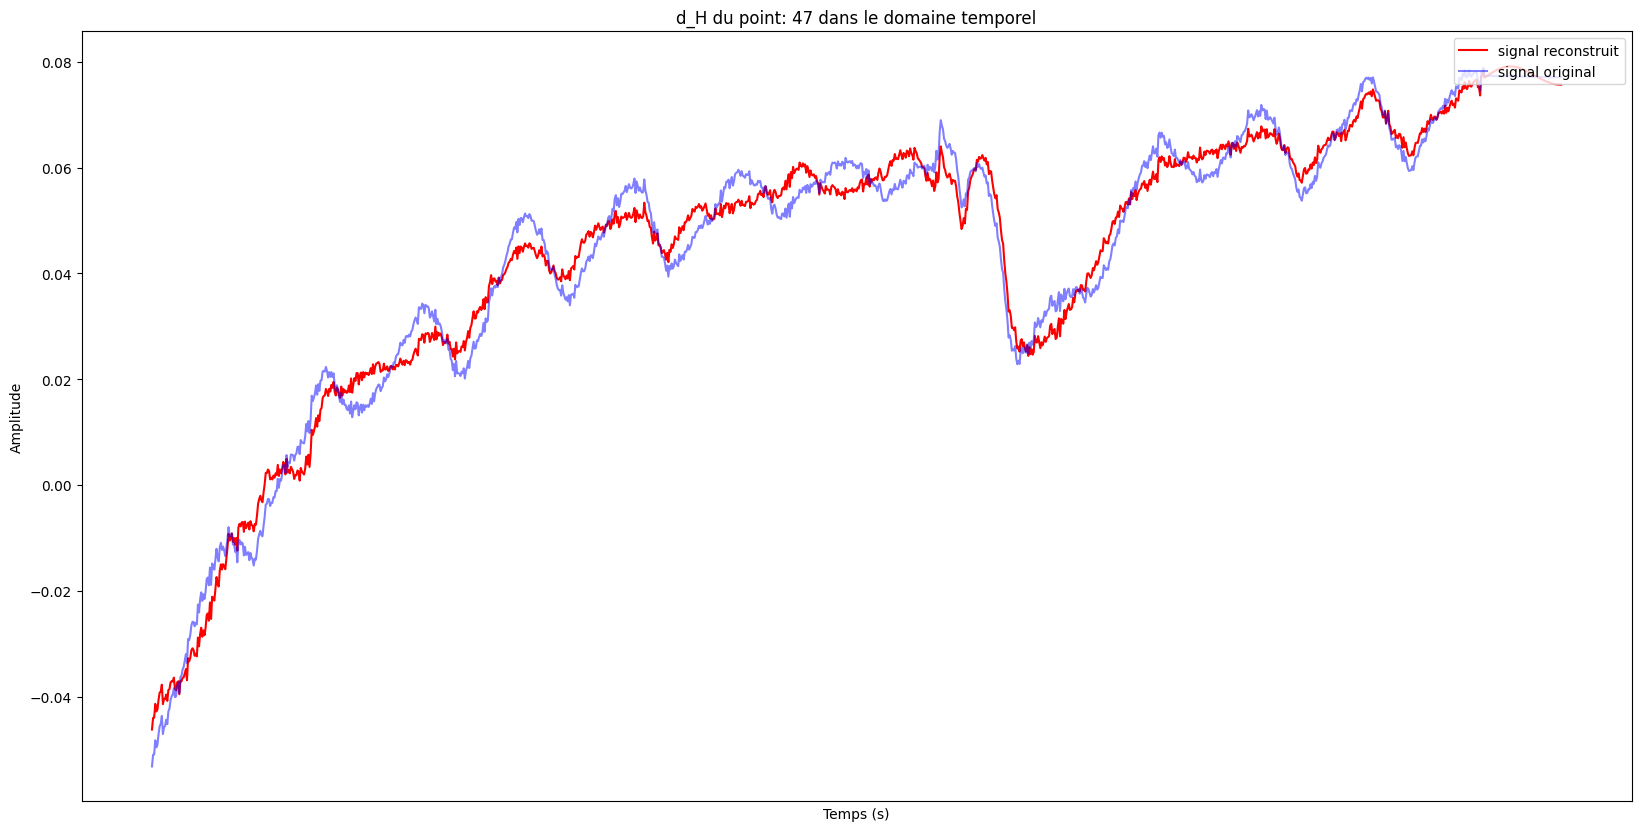

2578 2578
Point: 13
Point: 13


/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


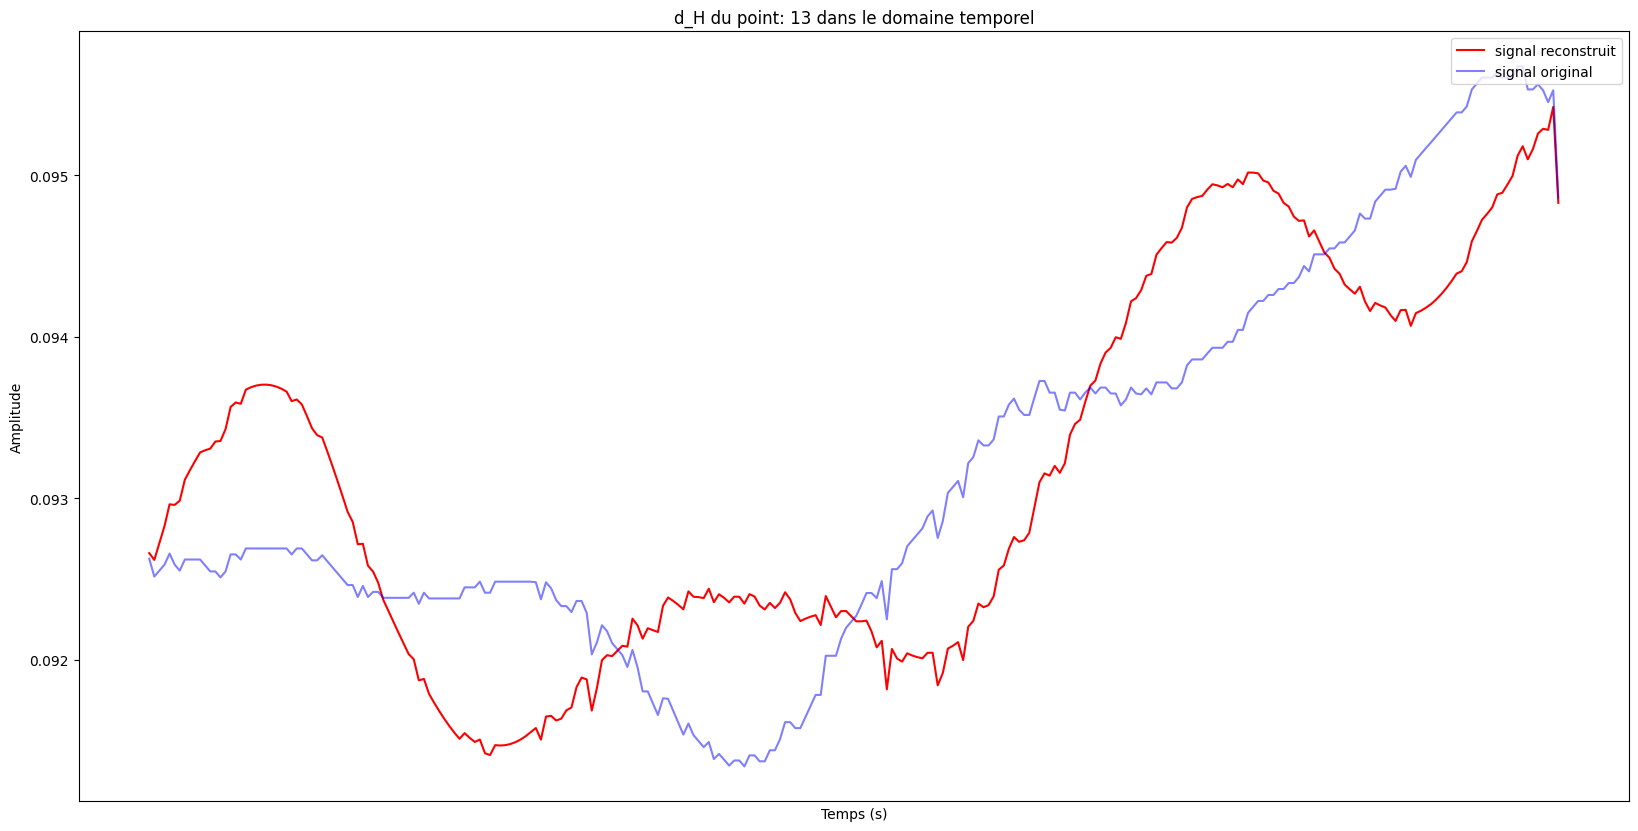

556 556
Point: 36
1525 1525
Point: 51
2087 2087
Point: 46
Point: 46


/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


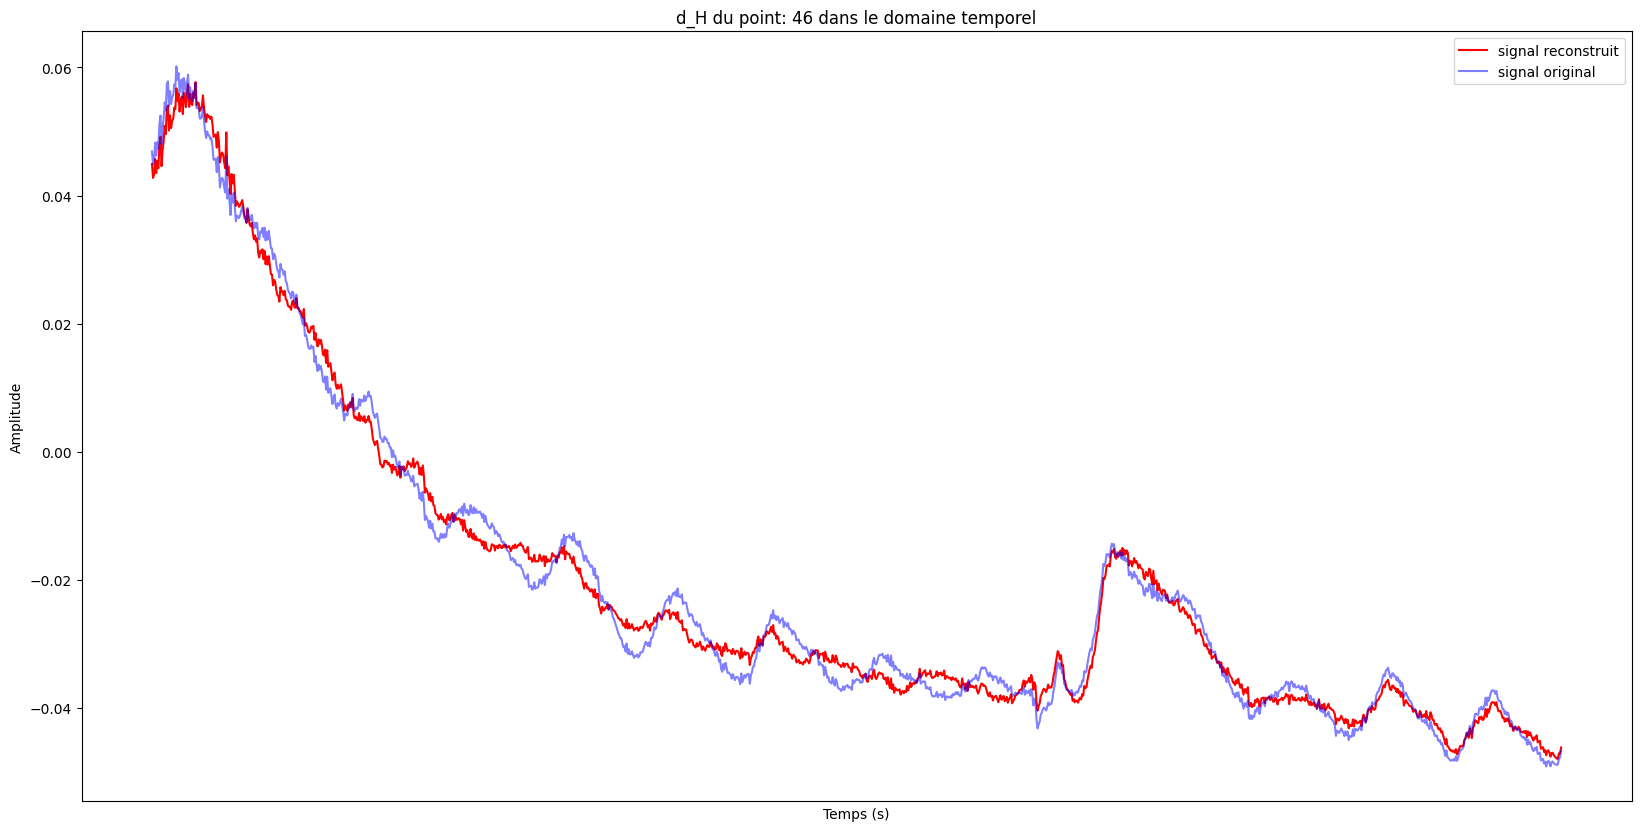

2655 2655
Point: 34
1271 1271
Point: 48
Point: 48


/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


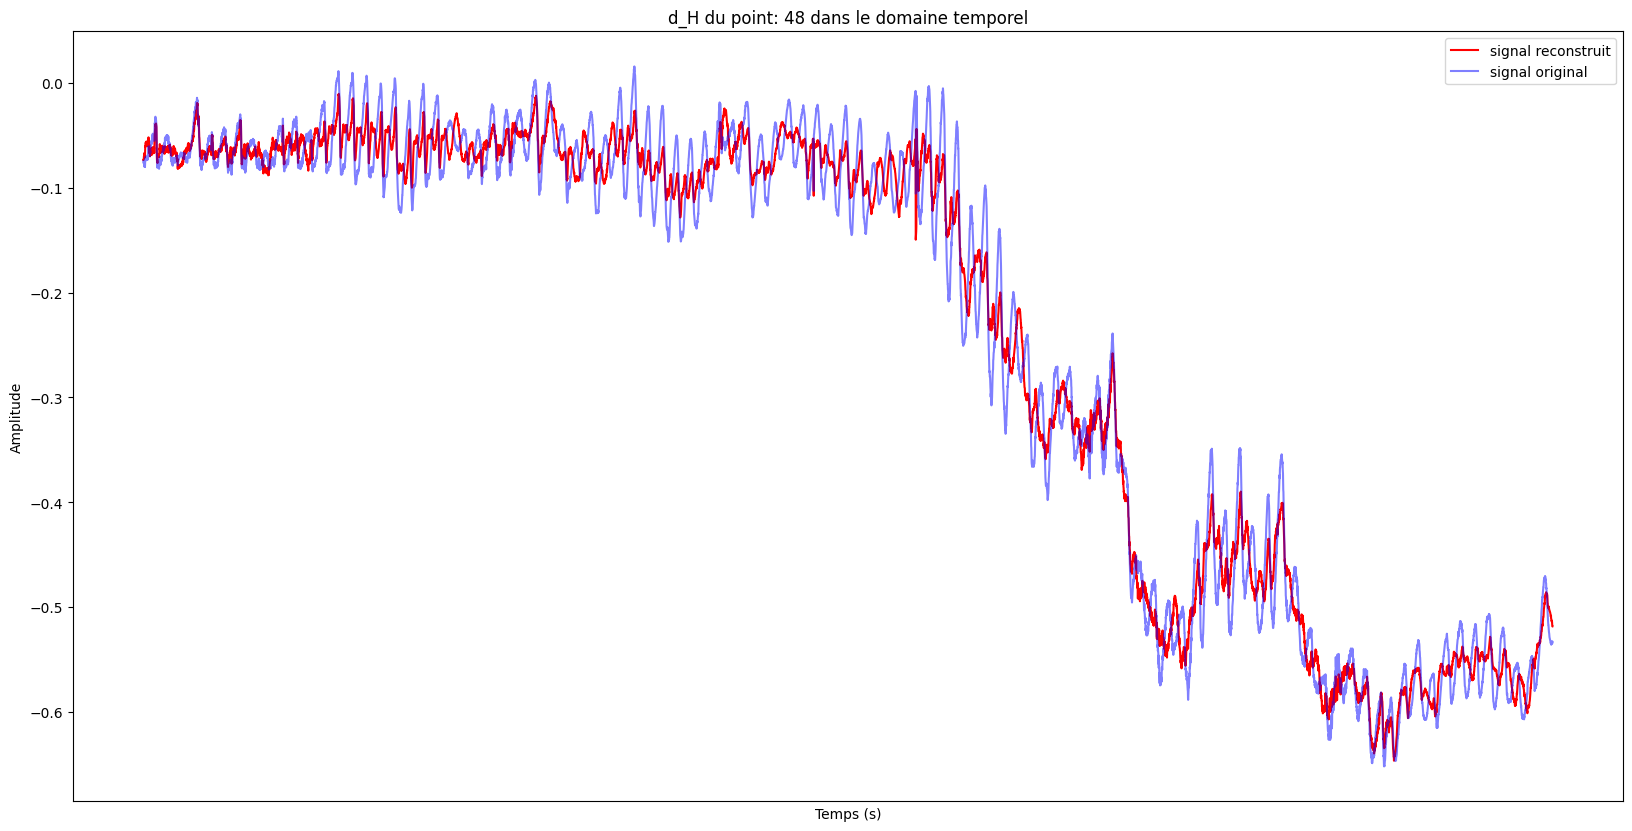

19172 19172


In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, ifft

for j in numeroPoints:
    print('Point: ' + j)

    K = numeroPoints.index(j)

    if j in point_correler:
       
        print('Point: ' + j)

        #choix des points de températures et de pression
        T_s_C = data[K]['pression2'][['temperature_stream','dates']]
        data_sample=np.array(T_s_C['temperature_stream'])
        data_abscisses=np.array(T_s_C['dates'])
        
        d_H = data[K]['pression2'][['dH','dates']]
        data_sample_dH = np.array(d_H['dH'])
        data_non_traite_dH = data_sample_dH.copy()
        #data_abscisses_dH=np.array(d_H['dates'])

        sample_rate=1/(15/60)

        data_non_correlé = []

        if j == '35' :
            d = int(len(data_sample_dH)*(1-0.1))
            data_non_correlé = data_sample_dH[d:]
            data_sample_dH = data_sample_dH[:d]
            plt.figure(figsize=(20,10))
            #plt.plot(data_abscisses, signal_reconstruit_dH , color='red', label='signal reconstruit')
            # plt.plot(data_abscisses[d:], data_non_correlé, color='blue', label='signal original', alpha=0.5)
            # plt.xlabel("Temps (s)")
            # plt.xticks([])
            # plt.ylabel("Amplitude")
            # plt.title("d_H filtré dans le domaine temporel")
            # plt.legend(loc='upper right')
            # plt.show()


        # Calculer la transformée de Fourier du signal audio
        fft_result_T = fft(data_sample)
        frequencies_T = fftfreq(len(fft_result_T), d=1/sample_rate)

        fft_result_dH = fft(data_sample_dH)
        frequencies_dH = fftfreq(len(fft_result_dH), d=1/sample_rate)

        #selection des fréquences entre ayant une periode d'environ 1 journée

        mask = np.where((frequencies_dH > 0.0385) & (frequencies_dH < 0.045), True, False)
        #mask[0]=False
        interval_peaks_half = np.where(mask)[0]

        #ajouter des fréquences symétriques

        interval_peaks=list(interval_peaks_half)
        for l in interval_peaks_half:
            interval_peaks.append(len(mask)-l)

        #copie du signal fft_result_dH

        fft_result_dH_copy=fft_result_dH.copy()

        # on met à 0 les fréquences qui ne sont pas dans le masque

        for l in interval_peaks:
            fft_result_dH_copy[l]=0

        # on reconstruit le signal 
            
        signal_reconstruit_dH = ifft(fft_result_dH_copy)

        if j == '35':
            signal_reconstruit_dH = list(signal_reconstruit_dH) + list(data_non_correlé)
            signal_reconstruit_dH = np.array(signal_reconstruit_dH)
            print(len(signal_reconstruit_dH),len(data_abscisses))

        # afficher signal reconstruit
        L=len(data_abscisses)//2
        plt.figure(figsize=(20,10))
        plt.plot(data_abscisses[L:], signal_reconstruit_dH[L:] , color='red', label='signal reconstruit')
        plt.plot(data_abscisses[L:], data_non_traite_dH[L:], color='blue', label='signal original', alpha=0.5)
        plt.xlabel("Temps (s)")
        plt.xticks([])
        plt.ylabel("Amplitude")
        plt.title("d_H du point: " + j + " dans le domaine temporel")
        plt.legend(loc='upper right')
        plt.show()

        # remplacer les valeurs de dH par les valeurs du signal reconstruit (dH_filtre)

        data[K]['pression2']['dH'] = signal_reconstruit_dH.real

        # plt.figure(figsize=(20,10))
        # plt.plot(data_sample, signal_reconstruit_dH)
        # plt.xlabel("T")
        # plt.ylabel("d_H filtré")
        # plt.title("d_H filtré dans le domaine temporel")
        # plt.show()

        # plt.figure(figsize=(20,10))
        # plt.plot(data_sample, data_non_traite_dH)
        # plt.xlabel("T")
        # plt.ylabel("d_H")
        # plt.title("d_H dans le domaine temporel")
        # plt.show()

    #exporter les données de dh filtré dans un dossier csv nommé pointX_dH.csv
    print(len(data[K]['pression2']['dates']), len(data[K]['temperature2']['dates']))
    export = pd.DataFrame(data[K]['pression2'])
    name_1 ='point'+ numeroPoints[K]+ '_pression_traité.csv'
    export.to_csv(name_1, index=False)  

    #déplacer le ficher csv dans le dossier data_traite

    os.replace(name_1, 'data_traite/' + name_1)

    #exporter les données de dh filtré dans un dossier csv nommé pointX_dH.csv

    export = pd.DataFrame(data[K]['temperature2'])
    name_2 ='point'+ numeroPoints[K]+ '_temperature_traité.csv'
    export.to_csv(name_2, index=False)  

    #déplacer le ficher csv dans le dossier data_traite

    os.replace(name_2, 'data_traite/' + name_2)


    

In [ ]:
#Point 47 afficher la moitié des points du signal traité et non traité





# Test



In [380]:
for i in point_correler:
    K=numeroPoints.index(i)

In [419]:
K=numeroPoints.index('48')
print(data[K])

{'numero': '48', 'nom': 'point48_14_04_18', 'date': '14_04_18', 'chemin': './raw_data/point48_14_04_18', 'capteur': 'p606', 'profondeur': 0, 'profondeurMesures': [10, 20, 30, 40], 'pression':                   dates  tension  temperature_stream        dH
0      14-04-2018 13:45  1.01682              13.778 -0.281872
1      14-04-2018 14:00  1.04383              13.660 -0.254874
2      14-04-2018 14:15  1.03117              13.595 -0.267265
3      14-04-2018 14:30  1.04120              13.538 -0.257211
4      14-04-2018 14:45  1.02647              13.401 -0.271494
...                 ...      ...                 ...       ...
19195  31-10-2018 19:20  0.76382              14.653 -0.534256
19196  31-10-2018 19:35  0.76538              14.652 -0.532709
19197  31-10-2018 19:50  0.76439              14.644 -0.533672
19198  31-10-2018 20:05  0.76340              14.628 -0.534617
19199  31-10-2018 20:20  0.76473              14.608 -0.533256

[19200 rows x 4 columns], 'temperature':           

In [420]:
T_s_C = data[K]['pression2'][['temperature_stream','dates']]
#print(T_s_C)
data_sample=np.array(T_s_C['temperature_stream'])
data_abscisses=np.array(T_s_C['dates'])

In [421]:
d_H = data[K]['pression2'][['dH','dates']]
#print(d_H)
data_sample_dH=np.array(d_H['dH'])
data_abscisses_dH=np.array(d_H['dates'])

In [422]:
correlation = np.corrcoef(data_sample, data_sample_dH)[0, 1]

# Afficher la corrélation
print(f"Corrélation entre température et pression : {correlation:.2f}")
r_squared = correlation**2
print(f"Coefficient de détermination (R²) : {r_squared:.2f}") 

Corrélation entre température et pression : 0.57
Coefficient de détermination (R²) : 0.32


In [423]:
# from scipy import signal

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq, ifft

sample_rate=1/(15/60)

# Calculer la transformée de Fourier du signal audio
fft_result_T = fft(data_sample)
frequencies_T = fftfreq(len(fft_result_T), d=1/sample_rate)

fft_result_dH = fft(data_sample_dH)
frequencies_dH = fftfreq(len(fft_result_dH), d=1/sample_rate)

#print(len(fft_result_dH))

# # Afficher le signal dans le domaine temporel
# plt.subplot(2, 1, 1)
# plt.plot(data_abscisses, data_sample)
# plt.xlabel("Temps (s)")
# plt.ylabel("Amplitude de Température")
# plt.title("Le temps")

# # Afficher le signal dans le domaine temporel
# plt.subplot(2, 1, 2)
# plt.plot(data_abscisses_dH, data_sample_dH)
# plt.xlabel("Temps (s)")
# plt.ylabel("Amplitude de dH")
# plt.title("Le temps")
# plt.show()

In [424]:
# Afficher le spectre de fréquence dans le domaine fréquentiel mask

#plt.plot(frequencies_T, np.abs(fft_result_T))
#plt.xlabel("Fréquence (Hz)")
#plt.ylabel("Amplitude spectrale de la température")
#plt.title("Spectre de fréquence")
#plt.show()

# Afficher le spectre de fréquence dans le domaine fréquentiel mask_dH
#plt.plot(frequencies_dH,np.abs(fft_result_dH))
#plt.xlabel("Fréquence (Hz)")
#plt.ylabel("Amplitude spectrale de dH")
#plt.title("Spectre de fréquence")
#plt.show()

In [444]:
#selection des fréquences entre -0,5Hz et 0,5 Hz:
#w = 0.5

mask = np.where((frequencies_dH > 0.0385) & (frequencies_dH < 0.045), True, False)
mask[0]=False
interval_peaks_half = np.where(mask)[0]

#mask_dH = np.where((frequencies_dH > -w) & (frequencies_dH < w), True, False)
#mask_dH[0]=False

#H=max(np.abs(fft_result_T[mask]))/4

# Trouver les pics dans le spectre des fréquences (peaks)

#peaks_T, _T = find_peaks(np.abs(fft_result_T[mask]), height=H)
#peaks_dH, _dH = find_peaks(np.abs(200*fft_result_dH[mask_dH]), height=0.1)

In [445]:
# interval_peaks_half =[]

#for i in peaks_T:
#     if i < len(mask)//2 :
#         interval_peaks_half.append(i) 

# for i in peaks_T:
#     l=-1
#     j=1
#     while np.abs(fft_result_T[i+j]) > 75  and i+j<len(mask):
#         interval_peaks_half.append(i+j)
#         j+=1
#     while np.abs(fft_result_T[i+l]) > 75  and i+l>0:
#         interval_peaks_half.append(i+l)
#         l-=1  

In [446]:

# while min(np.abs(frequencies_T[interval_peaks_half])) < 0.03: 
#     for i in np.where(frequencies_T[interval_peaks_half] == min(np.abs(frequencies_T[interval_peaks_half])))[0]:
#         if frequencies_T[i]>0.03:
#             print(i)
#             break
#         interval_peaks_half.remove(interval_peaks_half[i])
# while max(np.abs(frequencies_T[interval_peaks_half])) > 0.05: 
#     for i in np.where(frequencies_T[interval_peaks_half] == max(np.abs(frequencies_T[interval_peaks_half])))[0]:
#         if frequencies_T[i]<0.05 :
#             print(i)
#             break
#         interval_peaks_half.remove(interval_peaks_half[i])


In [447]:
interval_peaks=list(interval_peaks_half)
for i in interval_peaks_half:
    interval_peaks.append(len(mask)-i)
print(interval_peaks)

[185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 19015, 19014, 19013, 19012, 19011, 19010, 19009, 19008, 19007, 19006, 19005, 19004, 19003, 19002, 19001, 19000, 18999, 18998, 18997, 18996, 18995, 18994, 18993, 18992, 18991, 18990, 18989, 18988, 18987, 18986, 18985]


In [448]:
# Afficher le spectre de fréquence dans le domaine fréquentiel mask

#plt.plot(frequencies_T[mask], np.abs(fft_result_T[mask]))
#plt.xlabel("Fréquence (Hz)")
#plt.ylabel("Amplitude spectrale de la température")
#plt.title("Spectre de fréquence")
#plt.show()

# Afficher le spectre de fréquence dans le domaine fréquentiel mask_dH
#plt.plot(frequencies_dH[mask_dH],np.abs(fft_result_dH[mask_dH]))
#plt.xlabel("Fréquence (Hz)")
#plt.ylabel("Amplitude spectrale de dH")
#plt.title("Spectre de fréquence")
#plt.show()

In [449]:
#copie du signal fft_result_dH
fft_result_dH_copy=fft_result_dH.copy()

#on met à 0 les fréquences qui ne sont pas dans le masque
for i in interval_peaks:
        fft_result_dH_copy[i]=0


In [450]:
#plt.plot(frequencies_dH[mask],np.abs(fft_result_dH_copy[mask]))
#plt.xlabel("Fréquence (Hz)")
#plt.ylabel("Amplitude spectrale de dH")
#plt.title("Spectre de fréquence")
#plt.show()

In [451]:
#on reconstruit le signal     
signal_reconstruit_dH = ifft(fft_result_dH_copy)

#print(data[K]['pression2']['dH'])

#afficher signal reconstruit
# plt.figure(figsize=(20,10))
# plt.plot(data_abscisses_dH, signal_reconstruit_dH)
# plt.xlabel("Temps (s)")
# plt.ylabel("Amplitude")
# plt.title("d_H filtré dans le domaine temporel")
# plt.show()

# plt.figure(figsize=(20,10))
# plt.plot(data_abscisses_dH, data_sample_dH)
# plt.xlabel("Temps (s)")
# plt.ylabel("Amplitude")
# plt.title("d_H dans le domaine temporel")
# plt.show()

In [452]:
print(data[K]['pression2'])
data[K]['pression2']['dH'] = signal_reconstruit_dH.real
print(data[K]['pression2'])


                  dates  tension  temperature_stream        dH
0      14-04-2018 13:45  1.01682              13.778 -0.271879
1      14-04-2018 14:00  1.04383              13.660 -0.247331
2      14-04-2018 14:15  1.03117              13.595 -0.262196
3      14-04-2018 14:30  1.04120              13.538 -0.254627
4      14-04-2018 14:45  1.02647              13.401 -0.271395
...                 ...      ...                 ...       ...
19195  31-10-2018 19:20  0.76382              14.653 -0.512783
19196  31-10-2018 19:35  0.76538              14.652 -0.513391
19197  31-10-2018 19:50  0.76439              14.644 -0.516591
19198  31-10-2018 20:05  0.76340              14.628 -0.519843
19199  31-10-2018 20:20  0.76473              14.608 -0.520849

[19200 rows x 4 columns]
                  dates  tension  temperature_stream        dH
0      14-04-2018 13:45  1.01682              13.778 -0.268093
1      14-04-2018 14:00  1.04383              13.660 -0.242682
2      14-04-2018 14:15  1.03

In [453]:
#exporter les données de dh filtré dans un dossier csv nommé pointX_dH.csv

export = pd.DataFrame(data[K]['pression2'])

name ='point'+ numeroPoints[K]+ '_traité.csv'

export.to_csv(name, index=False)  

#déplacer le ficher csv dans le dossier data_traite

os.replace(name, 'data_traite/' + name)

In [454]:
correlation = np.corrcoef(data_sample, data_sample_dH)[0, 1]

 # Afficher la corrélation
print(f"Corrélation entre température et pression : {correlation:.2f}")

# Vous pouvez également calculer le coefficient de détermination (R²) pour évaluer la force de la corrélation.
r_squared = correlation**2
print(f"Coefficient de détermination (R²) : {r_squared:.2f}") 

Corrélation entre température et pression : 0.57
Coefficient de détermination (R²) : 0.32


In [455]:
correlation = np.corrcoef(data_sample, signal_reconstruit_dH.real)[0, 1]

 # Afficher la corrélation
print(f"Corrélation entre température et pression : {correlation:.2f}")

# Vous pouvez également calculer le coefficient de détermination (R²) pour évaluer la force de la corrélation.
r_squared = correlation**2
print(f"Coefficient de détermination (R²) : {r_squared:.2f}") 

Corrélation entre température et pression : 0.62
Coefficient de détermination (R²) : 0.39


/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


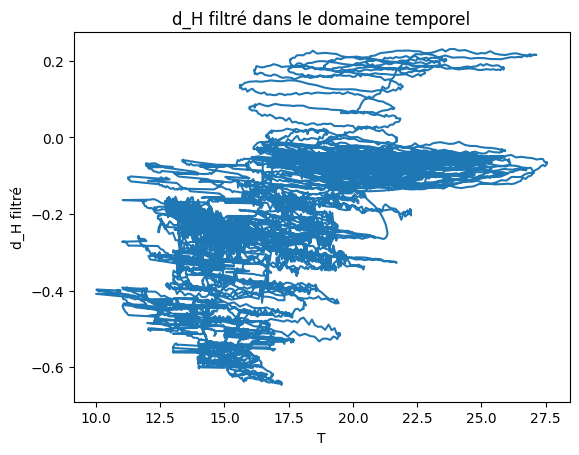

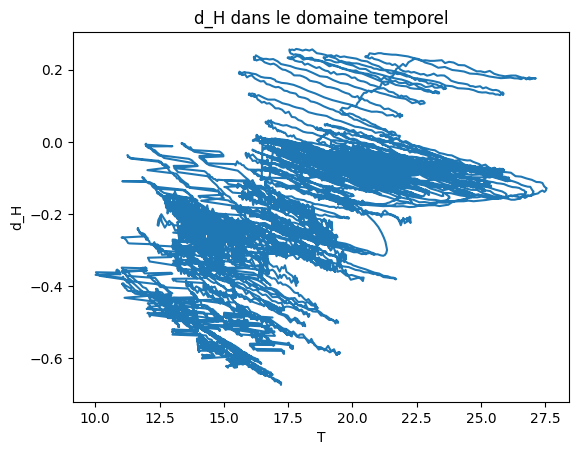

In [456]:
plt.plot(data_sample, signal_reconstruit_dH)
plt.xlabel("T")
plt.ylabel("d_H filtré")
plt.title("d_H filtré dans le domaine temporel")
plt.show()

plt.plot(data_sample, data_sample_dH)
plt.xlabel("T")
plt.ylabel("d_H")
plt.title("d_H dans le domaine temporel")
plt.show()

In [125]:
def traitement(k,data):
    T_s_C = data[k]['pression2'][['temperature_stream','dates']]
    data_sample=np.array(T_s_C['temperature_stream'])
    data_abscisses=np.array(T_s_C['dates'])

    d_H = data[k]['pression2'][['dH','dates']]
    data_sample_dH=np.array(d_H['dH'])
    data_abscisses_dH=np.array(d_H['dates'])

    # Afficher le signal dans le domaine temporel
    #plt.plot(data_abscisses, data_sample)

    # Afficher le signal dans le domaine temporel
    #plt.plot(data_abscisses_dH, data_sample_dH)
    #plt.xlabel("Temps (s)")
    #plt.ylabel("Amplitude")
    #plt.title("Le temps")
    #plt.show()

    plt.plot(data_sample,data_sample_dH)
    plt.xlabel("Amplitude de T")
    plt.ylabel("Amplitude de dH")
    plt.title("Le temps")
    plt.show()

    correlation = np.corrcoef(data_sample, data_sample_dH)[0, 1]

    # Afficher la corrélation
    #print(f"Corrélation entre température et pression : {correlation:.2f}")
    r_squared = correlation**2
    #print(f"Coefficient de détermination (R²) : {r_squared:.2f}") 
    if r_squared > 0.35: 
        
        sample_rate=1/(15*60)

        # Calculer la transformée de Fourier du signal audio
        fft_result_T = fft(data_sample)
        frequencies_T = fftfreq(len(fft_result_T), 1/sample_rate)

        fft_result_dH = fft(data_sample_dH)
        frequencies_dH = fftfreq(len(fft_result_dH), 1/sample_rate)

        #selection des fréquences entre -0,05Hz et 0,05 Hz:
        w=0.0002
        mask = np.where((frequencies_T > -w) & (frequencies_T < w), True, False)
        mask[0]=False

        mask_dH = np.where((frequencies_dH > -w) & (frequencies_dH < w), True, False)
        mask_dH[0]=False

        plt.plot(frequencies_T[mask], np.abs(fft_result_T[mask]))
        plt.xlabel("Fréquence (Hz)")
        plt.ylabel("Amplitude spectrale de la température")
        plt.title("Spectre de fréquence")
        plt.show()

        # Afficher le spectre de fréquence dans le domaine fréquentiel mask_dH
        plt.plot(frequencies_dH[mask_dH],np.abs(fft_result_dH[mask_dH]))
        plt.xlabel("Fréquence (Hz)")
        plt.ylabel("Amplitude spectrale de dH")
        plt.title("Spectre de fréquence")
        plt.show()

        # Trouver les pics dans le spectre des fréquences (peaks)
        h=max(np.abs(fft_result_T[mask]))/4
        peaks_T, _T = find_peaks(np.abs(fft_result_T[mask]), height=h)
        print(h)

        interval_peaks_half =[]
        for i in peaks_T:
            if i < len(mask)//2 :
                interval_peaks_half.append(i) 

        for i in peaks_T:
            l=-1
            j=1
            while np.abs(fft_result_T[i+j]) > 75  and i+j<len(mask):
                interval_peaks_half.append(i+j)
                j+=1
            while np.abs(fft_result_T[i+l]) > 75  and i+l>0:
                interval_peaks_half.append(i+l)
                l-=1  

        for i in interval_peaks_half:
            if np.abs(1/(frequencies_T[i]*60*60*24))>1.1 or np.abs(1/(frequencies_T[i]*60*60*24))<0.9:
                interval_peaks_half.remove(i)

        interval_peaks=list(interval_peaks_half)
        for i in interval_peaks_half:
            interval_peaks.append(len(mask)-i)
            
        print(interval_peaks)
        
        #copie du signal fft_result_dH
        fft_result_dH_copy=fft_result_dH.copy()

        #on met à 0 les fréquences qui ne sont pas dans le masque
        for i in interval_peaks:
            fft_result_dH_copy[i]=0

        plt.plot(frequencies_dH[mask_dH],np.abs(fft_result_dH_copy[mask_dH]))
        plt.xlabel("Fréquence (Hz)")
        plt.ylabel("Amplitude spectrale de dH")
        plt.title("Spectre de fréquence")
        plt.show()

        #on reconstruit le signal     
        signal_reconstruit_dH = ifft(fft_result_dH_copy)

        #afficher signal reconstruit
        plt.plot(data_abscisses_dH, signal_reconstruit_dH)
        plt.xlabel("Temps (s)")
        plt.ylabel("Amplitude")
        plt.title("d_H filtré dans le domaine temporel")
        plt.show()

        plt.plot(data_abscisses_dH, data_sample_dH)
        plt.xlabel("Temps (s)")
        plt.ylabel("Amplitude")
        plt.title("d_H dans le domaine temporel")
        plt.show()

        print("Nouveau coefficient de détermination (R²) :" , np.corrcoef(data_sample, signal_reconstruit_dH)[0, 1]**2) 

        #exporter les données de dh filtré dans un dossier csv nommé pointX_dH.csv
        data_abscisses_dH = pd.DataFrame(data_abscisses_dH)
        data_sample_dH = pd.DataFrame(signal_reconstruit_dH)
        name='point'+ numeroPoints[k]+ '_traité_dH.csv'
        data_abscisses_dH.to_csv(name, index=False)

        

        #déplacer le ficher csv dans le dossier data_traite
        os.replace(name, 'data_traite/' + name)




point traité est : 35


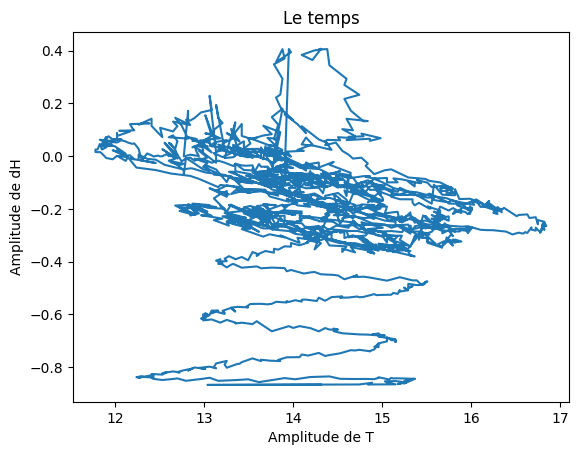

point traité est : 14


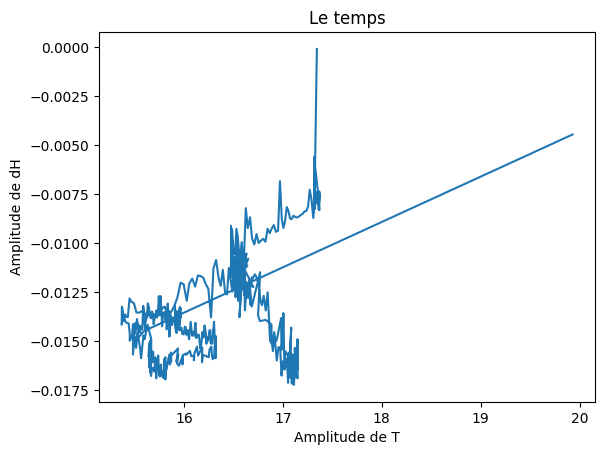

point traité est : 47


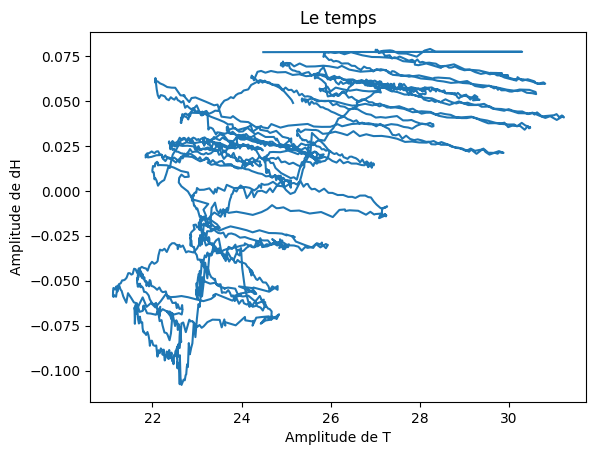

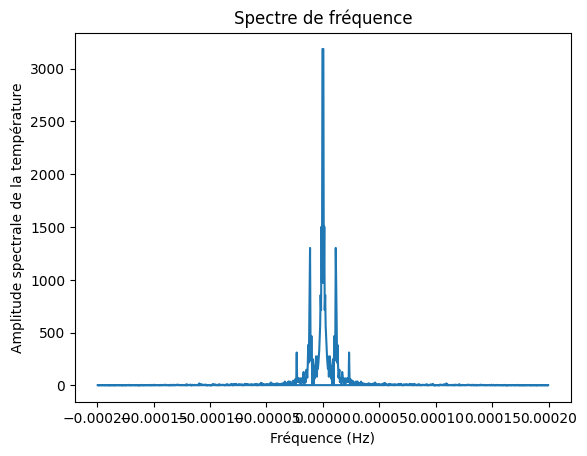

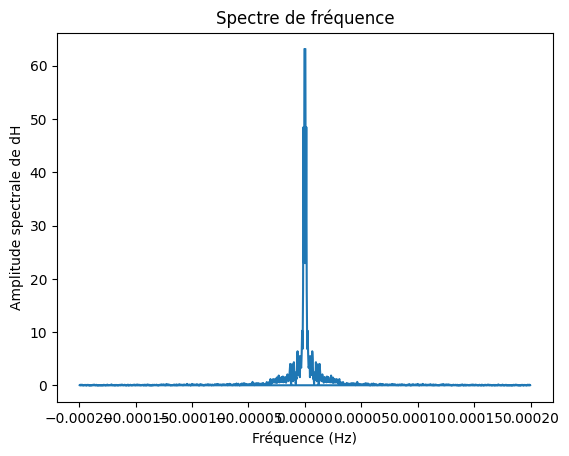

795.1461039540461
[27, 977, 4, 5, 7, 9, 11, 13, 15, 17, 5, 7, 9, 11, 13, 15, 17, 3, 2, 28, 29, 30, 31, 33, 26, 24, 2704, 1754, 2727, 2726, 2724, 2722, 2720, 2718, 2716, 2714, 2726, 2724, 2722, 2720, 2718, 2716, 2714, 2728, 2729, 2703, 2702, 2701, 2700, 2698, 2705, 2707]


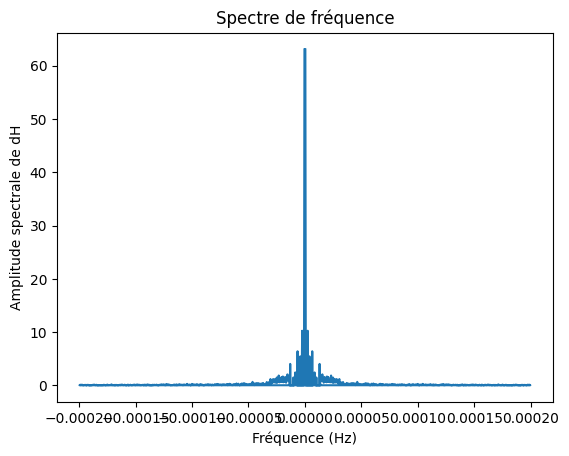

/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


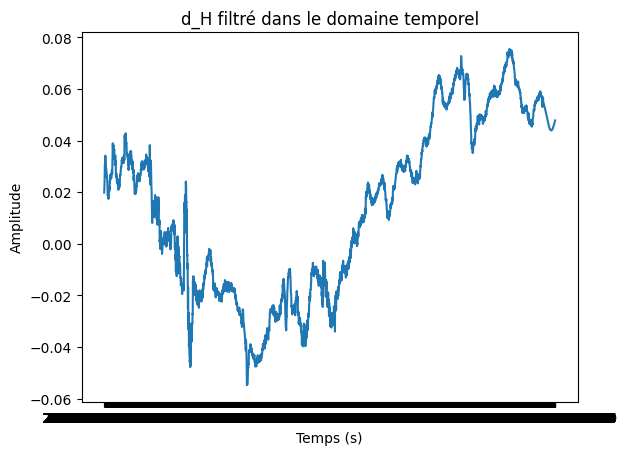

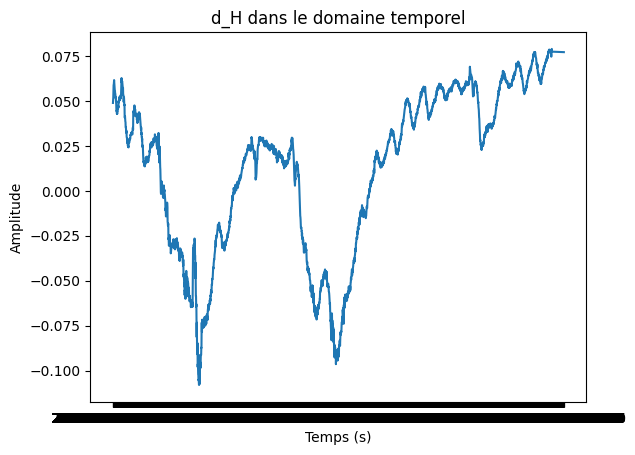

Nouveau coefficient de détermination (R²) : (0.4619411768194946-4.694288265241765e-17j)
point traité est : 13


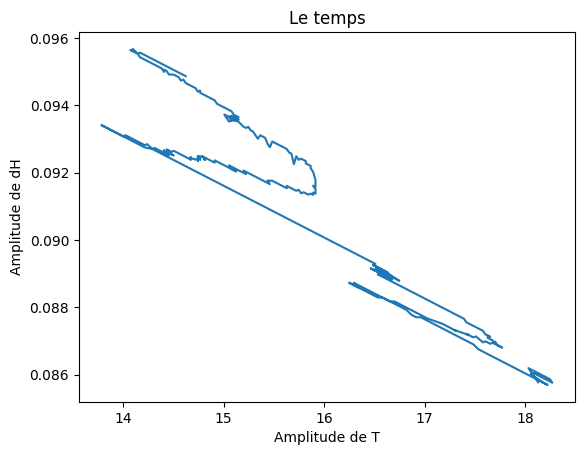

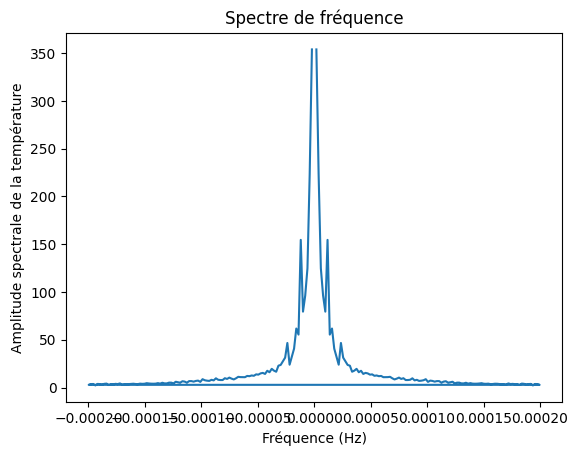

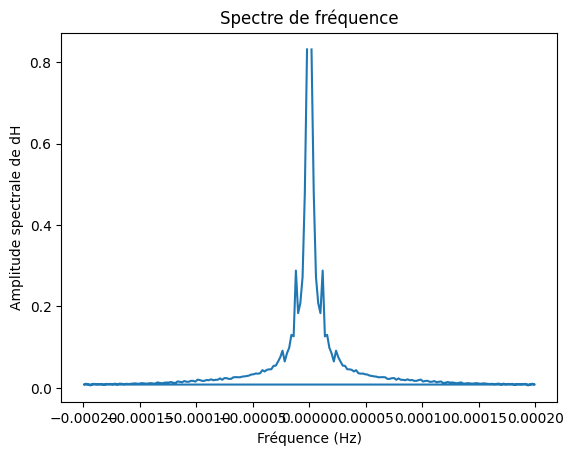

88.47544619879065
[196, 6, 3, 1, 366, 556, 559, 561]


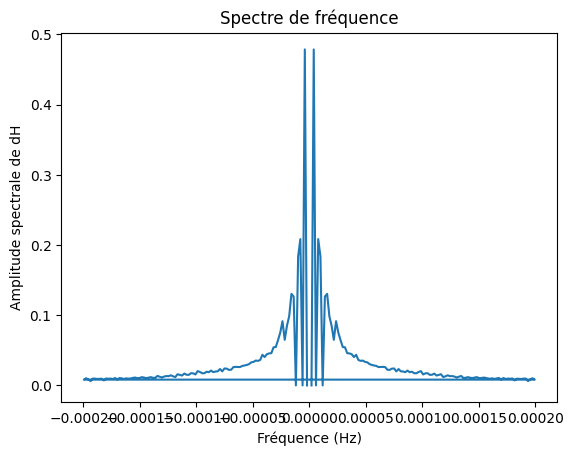

/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


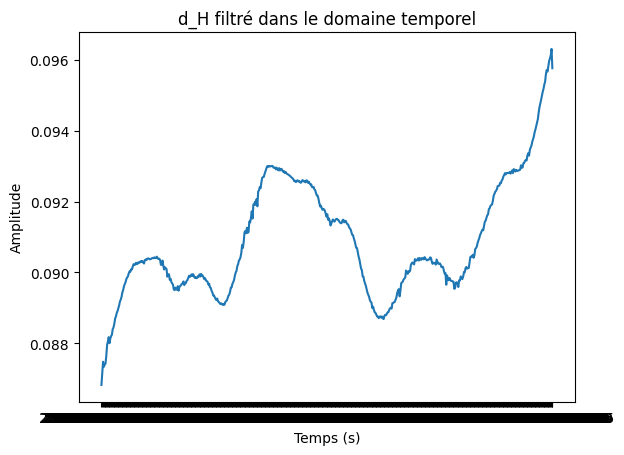

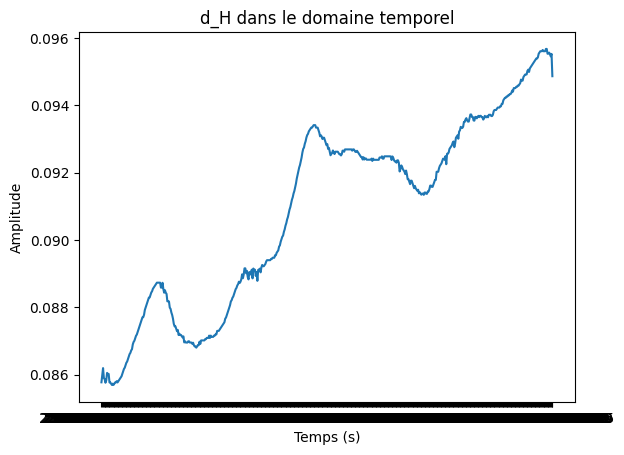

Nouveau coefficient de détermination (R²) : (0.303034826034309-3.1747815089073043e-16j)
point traité est : 36


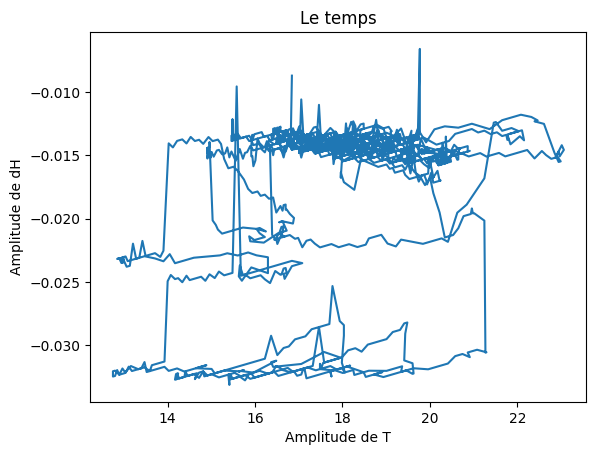

point traité est : 46


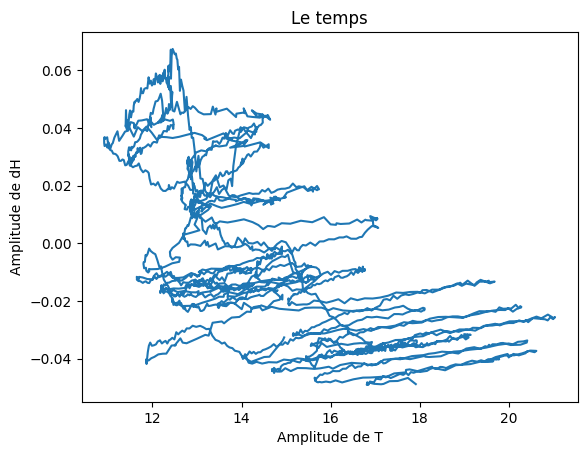

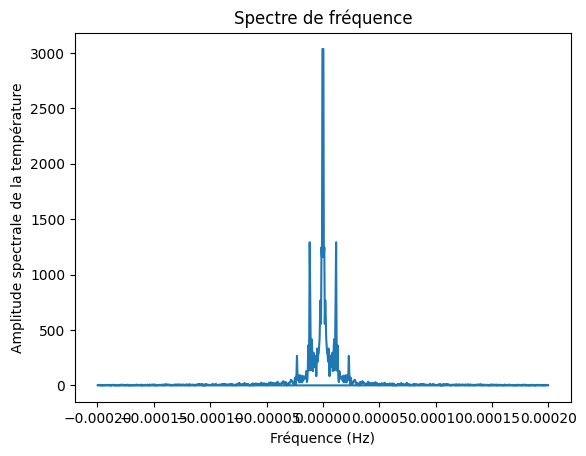

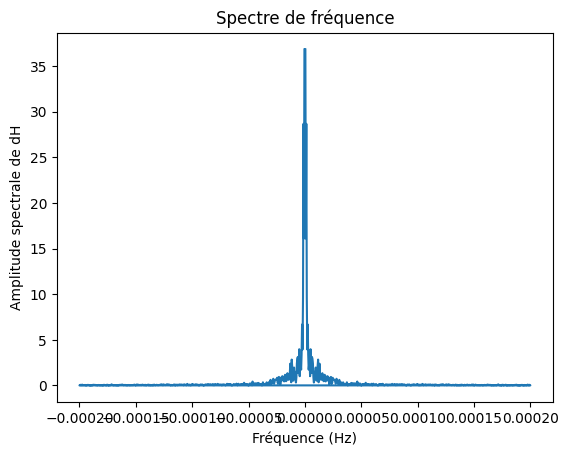

757.9553941961915
[27, 951, 4, 26, 27, 28, 29, 30, 32, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 32, 2, 28, 29, 30, 32, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 2629, 1705, 2652, 2630, 2629, 2628, 2627, 2626, 2624, 2651, 2649, 2647, 2645, 2643, 2641, 2639, 2637, 2635, 2633, 2631, 2630, 2629, 2628, 2627, 2626, 2624, 2654, 2628, 2627, 2626, 2624, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654]


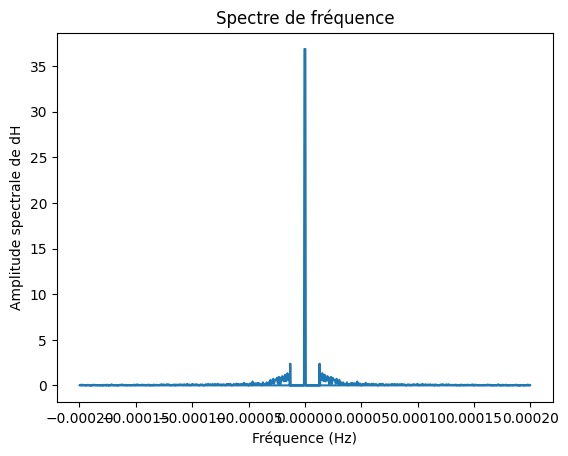

/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


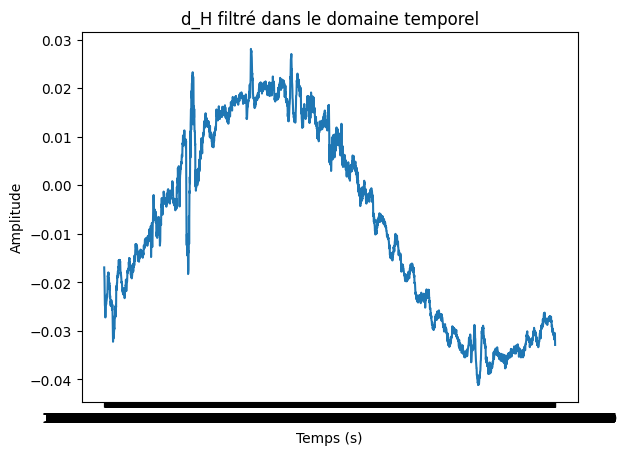

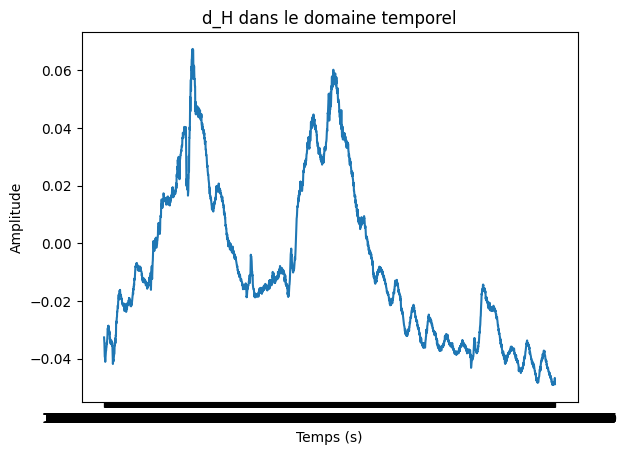

Nouveau coefficient de détermination (R²) : (0.44745893520137264-1.0384449730115616e-17j)
point traité est : 34


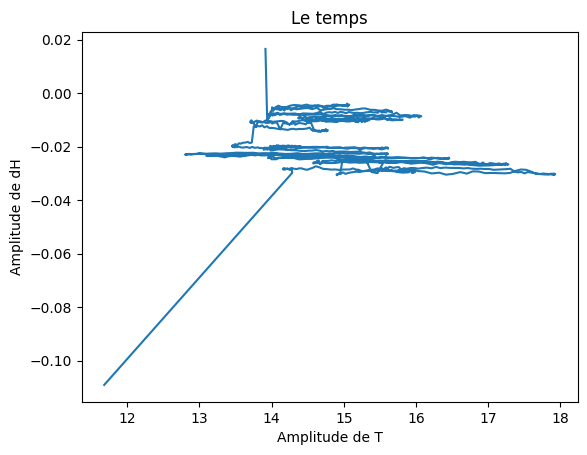

point traité est : 48


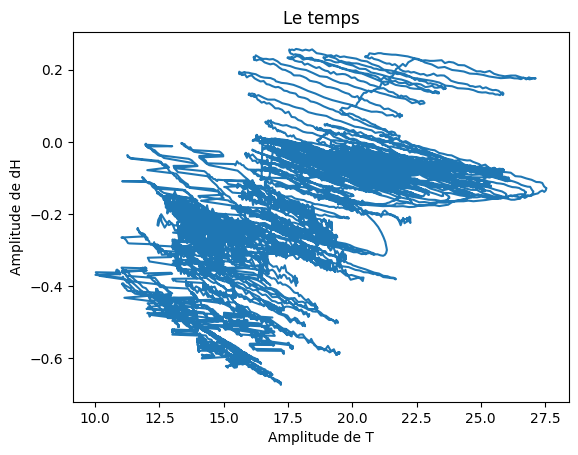

In [126]:
for i in range(len(numeroPoints)) :
    print("point traité est : " + numeroPoints[i])
    traitement(i,data)